# Task1: Data understanding and preparation 

1. [Import libraries](#import-libraries)
2. [Loading dataset](#loading-dataset)
3. [Merging the datasets](#merging-the-datasets)
4. [Attributes types](#attributes-types)
5. [Handling the attribute 'score'](#handling-the-attribute-score)
6. [Reducing the number of features](#reducing-the-number-of-features)
7. [Handling the attribute `ht` and `age`](#handling-the-attribute-ht-and-age)
8. [Syntactic accuracy](#syntactic-accuracy)
9. [Handling outliers of the original attributes](#handling-original-outliers)
10. [Analyzing the correlation](#analyzing-correlation)
11. [Handling the outliers of the new attributes](#handling-new-outliers)
12. [Handling missing values](#handling-missing-values)
    - [Handling missing values for the tournament](#handling-na-tourney)
    - [Handling missing values which have default values](#handling-na-default)
    - [Handling missing values for static attributes](#handling-na-static)
    - [Handling of missing values using central tendency](#handling-na-central)
    - [Using interpolation to fill missing values](#handling-na-interpolation)
13. [Creating players profiles](#creating-players-profiles)
14. [Correlation on new dataset](#correlation-new-dataset)
15. [PCA](#pca)


## Import libraries<a name="import-libraries"></a>

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sklearn

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from collections import defaultdict
from scipy.stats.stats import pearsonr
from scipy.stats import entropy, zscore

## Loading dataset <a name="loading-dataset"></a>

Read the .csv file containing the data. Each attribute of the datasets is separated by a '`,`'. The data is assigned to a Pandas dataframe.

In [2]:
df_matches = pd.read_csv('./data/tennis_matches.csv', sep=',')
df_males = pd.read_csv('./data/male_players.csv', sep=',')
df_females = pd.read_csv('./data/female_players.csv', sep=',')

We use the function `head`, to have a first look of the first 5 rows of the dataset matches, male and female players.

In [3]:
df_matches.head()

,Unnamed: 0,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
0,0,2019-M020,Brisbane,Hard,32.0,A,20181231.0,300.0,105453.0,NaN,...,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0,3928.0,742618.69
1,1,2019-M020,Brisbane,Hard,32.0,A,20181231.0,299.0,106421.0,NaN,...,7.0,10.0,10.0,13.0,16.0,1977.0,239.0,200.0,3928.0,742618.69
2,2,2019-M020,Brisbane,Hard,32.0,A,20181231.0,298.0,105453.0,NaN,...,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0,3928.0,742618.69
3,3,2019-M020,Brisbane,Hard,32.0,A,20181231.0,297.0,104542.0,PR,...,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0,3928.0,742618.69
4,4,2019-M020,Brisbane,Hard,32.0,A,20181231.0,296.0,106421.0,NaN,...,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0,3928.0,742618.69


In [4]:
df_males.head()

,name,surname
0,Gardnar,Mulloy
1,Pancho,Segura
2,Frank,Sedgman
3,Giuseppe,Merlo
4,Richard Pancho,Gonzales


In [5]:
df_females.head()

,name,surname
0,Bobby,Riggs
1,X,X
2,Martina,Hingis
3,Mirjana,Lucic
4,Justine,Henin


We can notice that the female players dataset has just an X as name and surname in the second instance which means that some records may be incomplete, but this is not an issue because later a left join will be performed which will drop them.

In the dataset there is a column with no name, we can rename it. It will uniquely identify each tennis match.

In [6]:
df_matches = df_matches.rename(columns={'Unnamed: 0': 'match_id'})

## Merging the datasets<a name="merging-the-datasets"></a>

We can see that in the male and female players dataset the amount of non-null objects of the `name` and `surname` columns is not the same, which means that some names and/or surnames are missing.

In [7]:
df_males.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55208 entries, 0 to 55207
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     55031 non-null  object
 1   surname  55166 non-null  object
dtypes: object(2)
memory usage: 862.8+ KB


In [8]:
df_females.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46172 entries, 0 to 46171
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     44505 non-null  object
 1   surname  46172 non-null  object
dtypes: object(2)
memory usage: 721.6+ KB


We create a new attribute name that includes both name and surname of the male and female players.

In [9]:
df_males['name'] = df_males['name'] + " " + df_males['surname']
df_males = df_males.drop(columns='surname')
df_males.head()

,name
0,Gardnar Mulloy
1,Pancho Segura
2,Frank Sedgman
3,Giuseppe Merlo
4,Richard Pancho Gonzales


In [10]:
df_females['name'] = df_females['name'] + " " + df_females['surname']
df_females = df_females.drop(columns='surname')
df_females.head()

,name
0,Bobby Riggs
1,X X
2,Martina Hingis
3,Mirjana Lucic
4,Justine Henin


We drop rows with empty cells and the duplicates from both the players dataset.

In [11]:
df_males = df_males.dropna()
print("Duplicated rows dropped in male players data set: "+str(df_males.duplicated().sum()))
df_males = df_males.drop_duplicates()

Duplicated rows dropped in male players data set: 475


In [12]:
df_females = df_females.dropna()
print("Duplicate rows dropped in female players data set: "+str(df_females.duplicated().sum()))
df_females = df_females.drop_duplicates()

Duplicate rows dropped in female players data set: 416


Now we add a new attribute to the male and female dataset that indicates the sex of the players. This attribute will be useful when we will join these two datasets to the tennis matches dataset.

In [13]:
df_males['sex'] = 'm'
df_females['sex'] = 'f'
df_males.head()
df_females.head()

,name,sex
0,Bobby Riggs,f
1,X X,f
2,Martina Hingis,f
3,Mirjana Lucic,f
4,Justine Henin,f


Now we can unify the two players datasets.

In [14]:
df_players = df_males.append(df_females, ignore_index=True)
print(df_players.head())
print(df_players.tail())

                      name sex
0           Gardnar Mulloy   m
1            Pancho Segura   m
2            Frank Sedgman   m
3           Giuseppe Merlo   m
4  Richard Pancho Gonzales   m
                 name sex
98640  Kathleen Allen   f
98641  Mrs Dransfield   f
98642   Jessie Greene   f
98643   Mary Trumbull   f
98644   Inga Sperling   f


We join the tennis dataset to the unified players dataset (taking care of the duplicate matches) using as a key the name of the players (that includes both `name` and `surname` of the original dataset).

In [15]:
# The part that is commented is just a check to see if after merging and dropping the tables are equals (i.e to check if we preserve the original matches)

print("Duplicated rows that were dropped: "+str(df_matches.duplicated(subset=df_matches.columns.values[1:]).sum())) #taking only a subset since the first col. has unique id (309)
#df_matches_copy = df_matches.drop_duplicates(subset=df_matches.columns.values[1:])
df_matches = df_matches.drop_duplicates(subset=df_matches.columns.values[1:])
df_matches = df_matches.reset_index(drop=True)
#df_matches_copy = df_matches_copy.reset_index(drop=True)
df_matches.info()

df_matches = df_matches.join(df_players.set_index(['name']), how='left', on=['winner_name'])
df_matches = df_matches.rename(columns={'sex': 'winner_sex'})
df_matches = df_matches.join(df_players.set_index(['name']), how='left', on=['loser_name'])
df_matches = df_matches.rename(columns={'sex': 'loser_sex'})
df_matches = df_matches.drop_duplicates(subset=['match_id'])
df_matches = df_matches.reset_index(drop=True)

df_matches.info()
#df_matches = df_matches.drop('winner_sex',1)
#df_matches = df_matches.drop('loser_sex', 1)
#print(df_matches_copy.equals(df_matches))

Duplicated rows that were dropped: 309
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185819 entries, 0 to 185818
Data columns (total 50 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   match_id            185819 non-null  int64  
 1   tourney_id          185764 non-null  object 
 2   tourney_name        185794 non-null  object 
 3   surface             185631 non-null  object 
 4   draw_size           185790 non-null  float64
 5   tourney_level       185790 non-null  object 
 6   tourney_date        185791 non-null  float64
 7   match_num           185792 non-null  float64
 8   winner_id           185764 non-null  float64
 9   winner_entry        25811 non-null   object 
 10  winner_name         185792 non-null  object 
 11  winner_hand         185773 non-null  object 
 12  winner_ht           49303 non-null   float64
 13  winner_ioc          185790 non-null  object 
 14  winner_age          182966 non-null  float64


Values that did not have a correspondence with the players dataset will have a missing value, so we solve with the real sex.

In [16]:
p_sex_na = set(df_matches[df_matches['winner_sex'].isna()]['winner_name'].unique())
p_sex_na.update(set(df_matches[df_matches['loser_sex'].isna()]['loser_name'].unique()))

print(p_sex_na)

#Jo-Wilfried Tsonga - m
#Taylor Fritz - m
#Christopher O'Connell - m
#Andres Artunedo Martinavarro - m
#Cristian Garin - m
#Stan Wawrinka - m
#Antoine Hoang - m
#Mackenzie McDonald - m
#Franko Skugor - m
#Diego Schwartzman - m
#Frances Tiafoe - m
#Pedro Martinez - m
#Daniel Elahi Galan - m
#Lloyd Harris - m
#Juan Martin del Potro - m
#Joao Menezes - m
#J.J. Wolf - m
#Evgenii Tiurnev - m
#David O'Hare - m
#Ben Patael - m
#Zeynep  Sena Sarioglan - f
#Alona Fomina - f
#Alexandar Lazov - m
#Daniel Munoz de la Nava - m
#Sam Groth - m
#Holger Rune - m
#Juan Pablo Varillas - m
#Jurabek Karimov - m
#Khumoun Sultanov - m
#Botic van de Zandschulp - m

{nan, 'Taylor Fritz', 'Stan Wawrinka', 'Juan Martin del Potro', 'Alexandar Lazov', 'Pedro Martinez', "Christopher O'Connell", 'Joao Menezes', 'Holger Rune', 'Antoine Hoang', 'J.J. Wolf', 'Jurabek Karimov', 'Alona Fomina', 'Frances Tiafoe', 'Daniel Elahi Galan', 'Cristian Garin', 'Sam Groth', 'Ben Patael', 'Jo-Wilfried Tsonga', 'Diego Schwartzman', 'Botic van de Zandschulp', 'Andres Artunedo Martinavarro', "David O'Hare", 'Franko Skugor', 'Juan Pablo Varillas', 'Mackenzie McDonald', 'Evgenii Tiurnev', 'Zeynep  Sena Sarioglan', 'Khumoun Sultanov', 'Daniel Munoz de la Nava', 'Lloyd Harris'}


In [17]:
df_matches.loc[df_matches['winner_name'] == "Zeynep  Sena Sarioglan", 'winner_sex'] = 'f'
df_matches.loc[df_matches['winner_name'] == "Alona Fomina", 'winner_sex'] = 'f'
df_matches.loc[df_matches['loser_name'] == "Zeynep  Sena Sarioglan", 'loser_sex'] = 'f'
df_matches.loc[df_matches['loser_name'] == "Alona Fomina", 'loser_sex'] = 'f'

df_matches.loc[df_matches['winner_name'].notna() & df_matches['winner_sex'].isna(), 'winner_sex'] = 'm'
df_matches.loc[df_matches['loser_name'].notna() & df_matches['loser_sex'].isna(), 'loser_sex'] = 'm'

print("Missing sex values for winners: "+str(df_matches.loc[df_matches['winner_sex'].isna() & df_matches['winner_name'].notna(), 'winner_sex'].sum()))
print("Missing sex values for losers: "+str(df_matches.loc[df_matches['loser_sex'].isna() & df_matches['loser_name'].notna(), 'loser_sex'].sum()))

Missing sex values for winners: 0
Missing sex values for losers: 0


We selected a list of attributes which were deemed as essential to characterize the matches and then we dropped the rows which have all the values for these attributes as NaN (i.e. missing values). A substantial amount of matches were dropped, this was necessary to have a definite dataset which could allow to extract some kind of knowledge for the matches.

In [18]:
col_to_consider = ['l_ace','w_ace','w_df','l_df','l_svpt','w_svpt','l_1stIn','w_1stIn','l_1stWon','w_1stWon','l_2ndWon','w_2ndWon','l_SvGms','w_SvGms','l_bpSaved','w_bpSaved','l_bpFaced','w_bpFaced']

print("Number of columns to consider: "+str(len(col_to_consider))) #18

num_rows_before = df_matches.shape[0] 
df_matches.dropna(how='all', subset=col_to_consider, inplace=True)
df_matches.drop(df_matches.loc[df_matches['winner_name'].isna() | df_matches['loser_name'].isna()].index, inplace=True) # we also drop rows where the name player is missing
df_matches.reset_index(drop=True, inplace=True)

print(f'rows dropped: {num_rows_before - df_matches.shape[0]} / {num_rows_before}')

Number of columns to consider: 18
rows dropped: 103824 / 185819


## Attributes types<a name="attributes-types"></a>

With the Pandas function `info()` we can get some information about the types of the attributes and check if there are any problems related to their representation.

In [19]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81995 entries, 0 to 81994
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   match_id            81995 non-null  int64  
 1   tourney_id          81986 non-null  object 
 2   tourney_name        81992 non-null  object 
 3   surface             81873 non-null  object 
 4   draw_size           81988 non-null  float64
 5   tourney_level       81991 non-null  object 
 6   tourney_date        81992 non-null  float64
 7   match_num           81990 non-null  float64
 8   winner_id           81986 non-null  float64
 9   winner_entry        10864 non-null  object 
 10  winner_name         81995 non-null  object 
 11  winner_hand         81975 non-null  object 
 12  winner_ht           42724 non-null  float64
 13  winner_ioc          81990 non-null  object 
 14  winner_age          81976 non-null  float64
 15  loser_id            81992 non-null  float64
 16  lose

With this function we identified 81995 rows and 51 attributes. In particular we can observe that there are 16 attributes that are dedicated to the winner of the match and other 16 attributes dedicated to the loser, this kind of redundancy is an issue for the dimensionality of our data that we will deal with later.

The attributes not specified are the following:
- `score`: the result of the tennis matches set.
- `round`: specify the round of the match that was played ('F', 'SF', 'QF', 'R16', 'R32', 'Q1', 'Q2', 'Q3', 'R64', 'R128', 'RR', 'BR')
- `tourney_spectators`: total spectators of a particular tourney
- `tourney_revenue`: total revenue of a particular tourney

There is also a problem with `tourney_date` that is represented as a `float` value. We can use the function `to_datetime()` to format these values.

In [20]:
df_matches['tourney_date'] = pd.to_datetime(df_matches['tourney_date'], format='%Y%m%d')
print(df_matches['tourney_date'].dtype)

datetime64[ns]


## Handling the attribute `score`<a name="handling-the-attribute-score"></a>

Here we deal with all the problems related to the attribute `score`.

In [21]:
df_matches.loc[df_matches['score'].str.contains("W/O", na=False)]

,match_id,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,...,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue,winner_sex,loser_sex
2252,2271,2019-M021,Madrid,Clay,64.0,PM,2019-05-06,274.0,201549.0,NaN,...,0.0,0.0,36.0,1470.0,4.0,5220.0,7075.0,1713855.57,f,f
2428,2449,2019-M009,Rome,Clay,64.0,P,2019-05-13,297.0,202428.0,NaN,...,0.0,0.0,4.0,5115.0,1.0,6356.0,7672.0,1673097.12,f,f
3331,3358,2019-M016,Eastbourne,Grass,64.0,P,2019-06-24,299.0,201493.0,NaN,...,0.0,0.0,5.0,4685.0,62.0,885.0,4516.0,868154.79,f,f
5931,6051,2018-M020,Brisbane,Hard,32.0,P,2018-01-01,250.0,215035.0,NaN,...,0.0,0.0,188.0,306.0,62.0,961.0,4154.0,741338.74,f,f
7645,7784,2018-M007,Miami,Hard,128.0,PM,2018-03-19,261.0,202469.0,NaN,...,0.0,0.0,3.0,5970.0,130.0,481.0,13375.0,3601609.54,f,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79557,117167,2020-1003,Doha,Hard,64.0,P,2020-02-24,289.0,201320.0,NaN,...,0.0,0.0,46.0,1178.0,29.0,1613.0,7051.0,1141012.26,f,f
79633,117243,2020-2011,Lyon,Hard,32.0,I,2020-03-02,292.0,206219.0,NaN,...,0.0,0.0,130.0,487.0,66.0,896.0,3487.0,452459.95,f,f
79844,117454,2020-1082,Prague,Clay,32.0,I,2020-08-10,287.0,202536.0,NaN,...,0.0,0.0,92.0,710.0,139.0,460.0,3342.0,706318.29,f,f
80356,117990,2018-1090,Bol,Clay,32.0,C,2018-06-05,298.0,202663.0,NaN,...,0.0,0.0,68.0,865.0,75.0,813.0,4231.0,787594.56,f,f


In [22]:
df_matches.drop(df_matches[df_matches['score'].str.contains("W/O", na=False)].index, inplace=True)

In [23]:
df_matches.loc[df_matches['score'].str.contains("DEF", na=False)]

,match_id,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,...,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue,winner_sex,loser_sex
23603,60423,2020-560,Us Open,Hard,128.0,G,2020-08-31,212.0,105807.0,NaN,...,1.0,2.0,27.0,1500.0,1.0,10860.0,10734.0,1337114.28,m,m
81138,162733,2016-M-DC-2016-G1-AM-M-CHI-COL-01,Davis Cup G1 R2: CHI vs COL,Clay,4.0,D,2016-07-15,4.0,106174.0,NaN,...,1.0,4.0,162.0,339.0,147.0,384.0,499.0,93069.07,m,m
81371,162974,2017-M-DC-2017-WG-M-CAN-GBR-01,Davis Cup WG R1: CAN vs GBR,Hard,4.0,D,2017-02-03,5.0,106378.0,NaN,...,2.0,5.0,47.0,988.0,234.0,223.0,417.0,79978.60,m,m


In [24]:
df_matches.loc[df_matches['score'].str.contains("Def.", na=False)]

,match_id,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,...,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue,winner_sex,loser_sex
2340,2360,2019-M009,Rome Masters,Clay,64.0,M,2019-05-13,283.0,134770.0,Q,...,2.0,5.0,76.0,695.0,36.0,1225.0,7672.0,1673097.12,m,m
13617,31219,2017-1086,St. Petersburg,Hard,32.0,P,2017-01-30,244.0,210722.0,NaN,...,4.0,11.0,85.0,755.0,166.0,340.0,2393.0,473260.59,f,f
25813,62682,2021-0807,Acapulco,Hard,32.0,A,2021-03-15,247.0,122298.0,NaN,...,7.0,9.0,149.0,489.0,125.0,599.0,3921.0,560824.91,m,m
26202,63072,2021-0425,Barcelona,Clay,64.0,A,2021-04-19,279.0,126523.0,Q,...,9.0,14.0,147.0,510.0,27.0,2048.0,5700.0,1050864.78,m,m
30913,67874,2016-0670,Binghamton CH,Hard,32.0,C,2016-07-18,279.0,105655.0,NaN,...,3.0,8.0,229.0,236.0,366.0,123.0,3169.0,641769.10,m,m
33357,70346,2016-5067,Savannah CH,Clay,32.0,C,2016-04-18,286.0,105385.0,NaN,...,0.0,1.0,84.0,671.0,260.0,199.0,3434.0,609798.78,m,m
36938,73952,2016-7345,Las Vegas CH,Hard,32.0,C,2016-10-17,277.0,105985.0,NaN,...,10.0,13.0,134.0,447.0,190.0,288.0,2353.0,443204.74,m,m
65575,103055,2019-6055,Charlottesville CH,Hard,64.0,C,2019-10-28,279.0,105985.0,NaN,...,3.0,7.0,169.0,298.0,278.0,152.0,7246.0,870543.53,m,m
65714,103194,2019-6307,Campinas CH,Clay,64.0,C,2019-09-30,271.0,105064.0,NaN,...,2.0,4.0,315.0,129.0,352.0,114.0,6837.0,1591141.27,m,m
66239,103722,2019-6857,Mouilleron-Le-Captif CH,Hard,64.0,C,2019-10-07,264.0,105731.0,NaN,...,3.0,7.0,158.0,340.0,232.0,203.0,5943.0,1352600.92,m,m


In [25]:
df_matches.loc[df_matches['score'].str.contains("Walkover", na=False)]

,match_id,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,...,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue,winner_sex,loser_sex


The attribute `score` is specified as a string and in this format will not be useful for our analysis. We process it to derive the number of games won/lost and the number of set won/lost for both the winner and the loser.

In [26]:
import re

def score_converter(row):
    if pd.notnull(row.score):
        games_won_p1 = 0 
        games_won_p2 = 0
        sets_won_p1 = 0
        sets_won_p2 = 0

        sets = row.score.strip().split(" ")
        for tennis_set in sets:
            set_games_won_p1 = 0
            set_games_won_p2 = 0

            a = tennis_set.split("-")

            # is RE == RET? tennis player withdrawal during the match
            if a[0] == "RET" or a[0] == "RE" or a[0] == "RET+H64":
                pass
            elif a[0] == 'Def.' or a[0] == 'DEF':
                pass
            elif a[0] == "":
                pass
            else:
                a[0] = a[0].replace('[', '')
                a[1] = a[1].replace(']', '')

                a0 = int(a[0])
                a1 = int(re.sub(r'\([^)]*\)', '', a[1]))

                if a0 > 7:
                    a0 = 7
                if a1 > 7:
                    a1 = 7

                set_games_won_p1 += a0
                set_games_won_p2 += a1

                if (set_games_won_p1 >= set_games_won_p2):
                    sets_won_p1 += 1
                elif(set_games_won_p1 < set_games_won_p2):
                    sets_won_p2 += 1

                games_won_p1 += set_games_won_p1
                games_won_p2 += set_games_won_p2

        if sets_won_p1 >= sets_won_p2:
            return [sets_won_p1, games_won_p1, sets_won_p2, games_won_p2, games_won_p1 + games_won_p2]
        elif sets_won_p1 < sets_won_p2:
            return [sets_won_p2, games_won_p2, sets_won_p1, games_won_p1, games_won_p1 + games_won_p2]


df_matches[['winner_sets', 'winner_games', 'loser_sets', 'loser_games', 'totalGames']] = df_matches.apply(score_converter, axis=1, result_type ='expand')
df_matches.head()

,match_id,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,...,loser_rank_points,tourney_spectators,tourney_revenue,winner_sex,loser_sex,winner_sets,winner_games,loser_sets,loser_games,totalGames
0,0,2019-M020,Brisbane,Hard,32.0,A,2018-12-31,300.0,105453.0,NaN,...,1977.0,3928.0,742618.69,m,m,2.0,15.0,1.0,12.0,27.0
1,1,2019-M020,Brisbane,Hard,32.0,A,2018-12-31,299.0,106421.0,NaN,...,200.0,3928.0,742618.69,m,m,2.0,13.0,0.0,8.0,21.0
2,2,2019-M020,Brisbane,Hard,32.0,A,2018-12-31,298.0,105453.0,NaN,...,1050.0,3928.0,742618.69,m,m,2.0,12.0,0.0,4.0,16.0
3,3,2019-M020,Brisbane,Hard,32.0,A,2018-12-31,297.0,104542.0,PR,...,1298.0,3928.0,742618.69,m,m,2.0,13.0,0.0,10.0,23.0
4,4,2019-M020,Brisbane,Hard,32.0,A,2018-12-31,296.0,106421.0,NaN,...,1855.0,3928.0,742618.69,m,m,2.0,18.0,1.0,14.0,32.0


## Reducing the number of features<a name="reducing-the-number-of-features"></a>

Here we remove the unnecessary features, those that are are redundant or unnnecessary.

Some useless features are `match_num`, `tourney_id`, `loser_id`, `winner_id` and `score`. We can remove them and still use `tourney_name` to do some other operations like counting the number of matches in a given tournament and the `score` has been used to extract other more useful attributes.

In [27]:
df_matches.drop(columns=['match_num','tourney_id','winner_id','loser_id','score'],inplace=True)

We remove all the semantically equivalent features that differ only to which player are applied (i.e. winner or loser). This process add a new feature that states if a player has won/lost the match.

In [28]:
def col_renamer(df):
    col_splitted = []
    col_changed = ""
    cols = []
    for col in df.columns:
        if "winner_" in col:
            col_changed = col.replace("winner_", "w_")
            col_splitted = col_changed.split('_')

            # winner_rank_points
            if len(col_splitted) == 3:
                col_splitted = [col_splitted[0], f"{col_splitted[1]}_{col_splitted[2]}"]
            df = df.rename(columns={col: f"{col_splitted[1]}_{col_splitted[0]}"})
        elif ("w_" in col or "l_" in col) and col != "draw_size":
            col_splitted = col.split('_')
            df = df.rename(columns={col: f"{col_splitted[1]}_{col_splitted[0]}"})
        elif "loser_" in col:
            col_changed = col.replace("loser_", "l_")
            col_splitted = col_changed.split('_')

            # loser_rank_points
            if len(col_splitted) == 3:
                col_splitted = [col_splitted[0], f"{col_splitted[1]}_{col_splitted[2]}"]
            df = df.rename(columns={col: f"{col_splitted[1]}_{col_splitted[0]}"})
        else:
            cols.append(col)

    return df, cols

df_matches, common_cols = col_renamer(df_matches)

print(common_cols)
df_matches = pd.wide_to_long(df_matches, 
    stubnames=['entry', 'name', 'hand', 'ht', 'ioc', 'age', 'ace',
     'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 
     'bpSaved', 'bpFaced', 'rank', 'rank_points', 'sets', 'games', 'sex'], 
    i=common_cols, 
    j='result', 
    sep='_', 
    suffix='[^_]+$')

df_matches = df_matches.reset_index()
df_matches.info()


['match_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level', 'tourney_date', 'best_of', 'round', 'minutes', 'tourney_spectators', 'tourney_revenue', 'totalGames']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163814 entries, 0 to 163813
Data columns (total 33 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   match_id            163814 non-null  int64         
 1   tourney_name        163808 non-null  object        
 2   surface             163570 non-null  object        
 3   draw_size           163800 non-null  float64       
 4   tourney_level       163806 non-null  object        
 5   tourney_date        163808 non-null  datetime64[ns]
 6   best_of             163804 non-null  float64       
 7   round               163802 non-null  object        
 8   minutes             162206 non-null  float64       
 9   tourney_spectators  163806 non-null  float64       
 10  tourney_revenue     163806 n

We print the first 5 rows of the updated dataset.

In [29]:
df_matches.head()

,match_id,tourney_name,surface,draw_size,tourney_level,tourney_date,best_of,round,minutes,tourney_spectators,...,1stWon,2ndWon,SvGms,bpSaved,bpFaced,rank,rank_points,sets,games,sex
0,0,Brisbane,Hard,32.0,A,2018-12-31,3.0,F,124.0,3928.0,...,31.0,17.0,13.0,3.0,6.0,9.0,3590.0,2.0,15.0,m
1,0,Brisbane,Hard,32.0,A,2018-12-31,3.0,F,124.0,3928.0,...,34.0,20.0,14.0,10.0,15.0,16.0,1977.0,1.0,12.0,m
2,1,Brisbane,Hard,32.0,A,2018-12-31,3.0,SF,82.0,3928.0,...,28.0,14.0,10.0,0.0,1.0,16.0,1977.0,2.0,13.0,m
3,1,Brisbane,Hard,32.0,A,2018-12-31,3.0,SF,82.0,3928.0,...,36.0,7.0,10.0,10.0,13.0,239.0,200.0,0.0,8.0,m
4,2,Brisbane,Hard,32.0,A,2018-12-31,3.0,SF,66.0,3928.0,...,26.0,9.0,8.0,2.0,2.0,9.0,3590.0,2.0,12.0,m


Since we established that for players with less than five matches it was difficult to create a significative profile we decided to drop them

In [30]:
df_matches = df_matches.groupby('name').filter(lambda x: x.shape[0] >= 5) #drop players with less than 5 matches

We group players by their nationality to have a "feeling" of how the players are partitioned among the different nationalities.

In [31]:
df_plt = df_matches
df_plt = df_plt.groupby('ioc', dropna=False).apply(
    lambda x: x.assign(
        ioc = x['ioc'] if x['ioc'].shape[0] > 500 else 'ROW' 
    )
)

<AxesSubplot:xlabel='count', ylabel='ioc'>

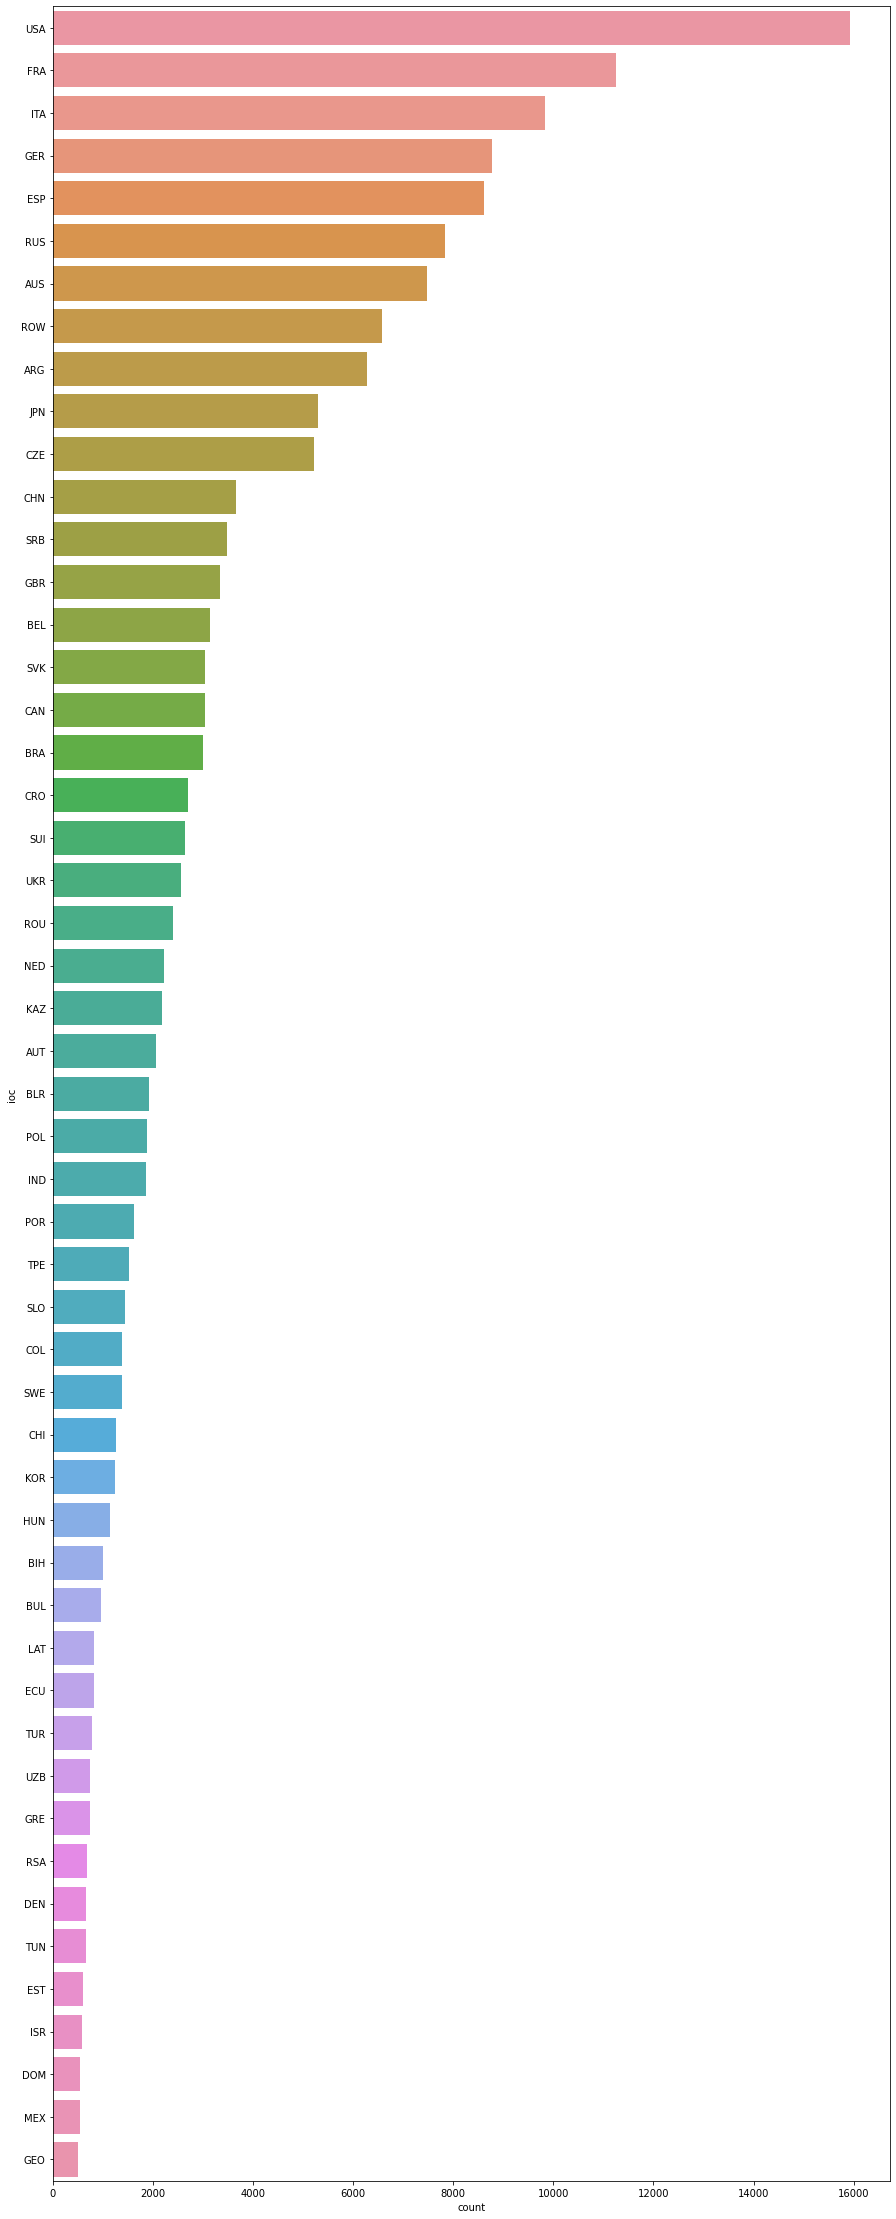

In [32]:
plt.figure(figsize=(15,40))
sns.countplot(y="ioc", data=df_plt, order = df_plt['ioc'].value_counts().index)

We further explore the dataset examining how the dataset is partitioned between male and female players and their hand used for the services, noticing a prevalence of male players and the usage of the right hand.

<AxesSubplot:xlabel='sex', ylabel='count'>

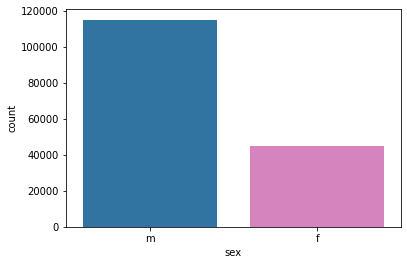

In [33]:
sns.countplot(x="sex", data=df_matches, palette=['tab:blue', 'tab:pink'])

<AxesSubplot:xlabel='sex', ylabel='count'>

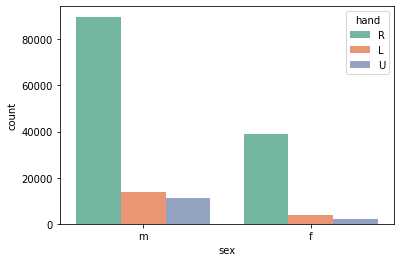

In [34]:
sns.countplot(x="sex", hue="hand", data=df_matches, palette="Set2")

## Handling the attribute `ht` and `age` <a name="handling-the-attribute-ht-and-age"></a>

The attributes `ht` and `age` of a player are expressed in relation with the tournament date. In this section we replace them with the max value (most recent value).

In [35]:
df_matches = df_matches.groupby('name', dropna=False).apply(
    lambda x: x.assign(
        age=x[x['tourney_date'] == x.tourney_date.max()].age.iloc[0], 
        ht=x[x['tourney_date'] == x.tourney_date.max()].ht.iloc[0])
    )

df_matches = df_matches.sort_values(by=['match_id'])
df_matches = df_matches.reset_index(drop=True)
df_matches.head()

,match_id,tourney_name,surface,draw_size,tourney_level,tourney_date,best_of,round,minutes,tourney_spectators,...,1stWon,2ndWon,SvGms,bpSaved,bpFaced,rank,rank_points,sets,games,sex
0,0,Brisbane,Hard,32.0,A,2018-12-31,3.0,F,124.0,3928.0,...,31.0,17.0,13.0,3.0,6.0,9.0,3590.0,2.0,15.0,m
1,0,Brisbane,Hard,32.0,A,2018-12-31,3.0,F,124.0,3928.0,...,34.0,20.0,14.0,10.0,15.0,16.0,1977.0,1.0,12.0,m
2,1,Brisbane,Hard,32.0,A,2018-12-31,3.0,SF,82.0,3928.0,...,28.0,14.0,10.0,0.0,1.0,16.0,1977.0,2.0,13.0,m
3,1,Brisbane,Hard,32.0,A,2018-12-31,3.0,SF,82.0,3928.0,...,36.0,7.0,10.0,10.0,13.0,239.0,200.0,0.0,8.0,m
4,2,Brisbane,Hard,32.0,A,2018-12-31,3.0,SF,66.0,3928.0,...,26.0,9.0,8.0,2.0,2.0,9.0,3590.0,2.0,12.0,m


In [36]:
df_matches.describe()

,match_id,draw_size,best_of,minutes,tourney_spectators,tourney_revenue,totalGames,ht,age,ace,...,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,rank,rank_points,sets,games
count,159922.000000,159908.000000,159912.000000,158362.000000,159914.000000,1.599140e+05,159912.000000,79049.000000,159903.000000,159914.000000,...,159910.000000,159912.000000,159907.000000,159914.000000,159911.000000,159907.000000,157842.000000,157815.000000,159912.000000,159912.000000
mean,72038.146278,50.517398,3.078331,98.308938,5081.457715,1.013904e+06,22.709784,182.268871,28.494323,4.236164,...,44.650272,30.327868,13.675249,11.080718,4.100512,7.106599,230.467613,717.616101,1.209203,11.416367
std,35864.733740,32.947402,0.387977,41.330708,3536.175634,7.873032e+05,6.830313,8.992652,4.417313,4.187927,...,16.813609,11.948016,6.175382,3.496257,3.183687,4.446529,243.069555,1172.516782,0.918526,4.388566
min,0.000000,2.000000,3.000000,0.000000,97.000000,1.934754e+04,0.000000,145.000000,15.770021,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,57038.250000,32.000000,3.000000,72.000000,2947.000000,5.744803e+05,18.000000,176.000000,25.171800,1.000000,...,33.000000,22.000000,9.000000,9.000000,2.000000,4.000000,77.000000,158.000000,0.000000,8.000000
50%,77864.500000,32.000000,3.000000,92.000000,3662.000000,7.293111e+05,21.000000,183.000000,28.377823,3.000000,...,42.000000,29.000000,13.000000,10.000000,4.000000,7.000000,163.000000,357.000000,2.000000,12.000000
75%,98855.000000,64.000000,3.000000,120.000000,6366.000000,1.191763e+06,27.000000,188.000000,31.342916,6.000000,...,54.000000,37.000000,17.000000,14.000000,6.000000,10.000000,298.000000,775.000000,2.000000,14.000000
max,186124.000000,128.000000,5.000000,4756.000000,18086.000000,5.002794e+06,65.000000,211.000000,46.598220,75.000000,...,1330.000000,836.000000,399.000000,50.000000,209.000000,266.000000,2251.000000,16950.000000,3.000000,33.000000


In [37]:
df_matches.drop(labels='match_id', axis=1, inplace=True)
df_matches.reset_index(drop=True, inplace=True)

Now we approximate the attribute `age` and `ht` to the floor value and convert them to integers.

In [38]:
df_matches['age'] = df_matches['age'].apply(np.floor)
df_matches['ht'] = df_matches['ht'].apply(np.floor)
print(df_matches['age'])
print(df_matches['ht'])

0         31.0
1         25.0
2         25.0
3         36.0
4         31.0
          ... 
159917    28.0
159918    23.0
159919    22.0
159920    24.0
159921    22.0
Name: age, Length: 159922, dtype: float64
0         178.0
1         198.0
2         198.0
3         188.0
4         178.0
          ...  
159917      NaN
159918      NaN
159919      NaN
159920    175.0
159921      NaN
Name: ht, Length: 159922, dtype: float64


A scatter plot matrix showing the now fixed height and age of the tennis players divided into males and females, we can observe the presence of outliers which will be handled later.

<AxesSubplot:xlabel='age', ylabel='ht'>

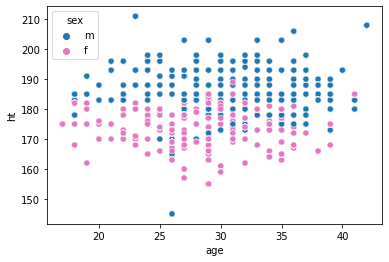

In [39]:
sns.scatterplot(x="age", y='ht', data=df_matches, hue="sex", palette=['tab:blue', 'tab:pink'])

## Syntactic accuracy <a name="syntactic-accuracy"></a>
We check if the values of the attributes correspond to those in the defined domain.

In [40]:
df_matches['surface'].unique()

array(['Hard', 'Clay', 'Grass', nan, 'Carpet'], dtype=object)

For instance the domain for the `surface` attribute value contains only valid values

In [41]:
df_matches['tourney_level'].unique()

array(['A', 'P', 'G', 'I', 'M', 'PM', 'F', 'D', 'C', 'O', 'W', nan],
      dtype=object)

Further inspection reveals that the attribute `tourney_level` has extra values which were not described, which are:
- `W` which stands for WTA (Women's Tournament Association) tournaments
- `O` which stands for Olympics matches

In [42]:
df_matches['entry'].unique()

array([nan, 'PR', 'Q', 'LL', 'WC', 'Alt', 'A', 'SE', 'ALT', '3', '4', '6',
       'SR', 'ITF', 'P', 'I', 'J'], dtype=object)

Also the attribute `entry` has some extra values which were not described, which are: 
- `SE` which  stands for 'Special Exempt'
- `Alt` or `ALT` or `A` which stand for Alternate
- `SR` which stands for Special Ranking'
- `JE` which stands for 'Junior exempt'
- `JR` which stands for 'Junior'
- `IR` which stands for 'ITF reserved'
- `P` which means that the player has a ITF direct acceptance
- `I` which is equivalent to 'Qualifier'

There are also the extra values `3`, `4`, `6` which stands for the top seeds for that tournament.

## Handling outliers of the original attributes<a name="handling-original-outliers"></a>

In this section we handle the possible outliers of the original attributes.

We use the `describe()` function to have some statistics of the attributes and to analyze possible "weird" values that could be out of bounds, e.g. the maximum value for minutes is 2475 which is roughly 41 hours.

In [43]:
df_matches[df_matches['sex'] == 'm'].describe()

,draw_size,best_of,minutes,tourney_spectators,tourney_revenue,totalGames,ht,age,ace,df,...,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,rank,rank_points,sets,games
count,115072.000000,115072.000000,113826.000000,115072.000000,1.150720e+05,115070.000000,52351.000000,115060.000000,115070.000000,115070.000000,...,115070.000000,115070.000000,115070.000000,115072.000000,115070.000000,115070.000000,113342.000000,113313.000000,115070.000000,115070.000000
mean,47.215170,3.108854,98.886572,4748.219237,9.505894e+05,23.189233,186.527554,28.232653,4.897254,3.030269,...,44.866568,31.363422,14.297506,11.369612,3.940228,6.630242,270.499779,563.574647,1.221813,11.657956
std,28.801225,0.453718,41.934619,3105.876295,6.907895e+05,7.096162,6.913926,4.498451,4.463763,2.371530,...,16.332509,11.985560,6.168136,3.515682,3.062167,4.165576,263.653271,1092.950772,0.927442,4.451432
min,4.000000,3.000000,0.000000,216.000000,4.066481e+04,0.000000,145.000000,15.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,32.000000,3.000000,72.000000,2924.000000,5.744812e+05,18.000000,183.000000,25.000000,2.000000,1.000000,...,33.000000,23.000000,10.000000,9.000000,2.000000,4.000000,102.000000,123.000000,0.000000,8.000000
50%,32.000000,3.000000,92.000000,3603.000000,7.129379e+05,22.000000,185.000000,28.000000,4.000000,3.000000,...,42.000000,30.000000,14.000000,11.000000,3.000000,6.000000,206.000000,266.000000,2.000000,12.000000
75%,64.000000,3.000000,120.000000,5697.000000,1.082827e+06,28.000000,190.000000,31.000000,7.000000,4.000000,...,54.000000,38.000000,18.000000,14.000000,6.000000,9.000000,346.000000,587.000000,2.000000,14.000000
max,128.000000,5.000000,4756.000000,18086.000000,5.002794e+06,65.000000,211.000000,46.000000,75.000000,26.000000,...,218.000000,171.000000,56.000000,50.000000,27.000000,35.000000,2251.000000,16950.000000,3.000000,33.000000


In [44]:
df_matches[df_matches['sex'] == 'f'].describe()

,draw_size,best_of,minutes,tourney_spectators,tourney_revenue,totalGames,ht,age,ace,df,...,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,rank,rank_points,sets,games
count,44836.000000,44840.0,44536.000000,44842.000000,4.484200e+04,44842.000000,26698.000000,44843.000000,44844.000000,44843.000000,...,44840.000000,44842.000000,44837.000000,44842.000000,44841.000000,44837.000000,44500.000000,44502.00000,44842.000000,44842.000000
mean,58.992595,3.0,96.832607,5936.602850,1.176378e+06,21.479461,173.918196,27.437995,2.539805,3.684522,...,44.095205,27.670510,12.078284,10.339369,4.511831,8.329125,128.505236,1109.84340,1.176843,10.796419
std,40.531788,0.0,39.707841,4338.540785,9.742992e+05,5.920290,6.356732,4.167634,2.723275,2.843109,...,17.977733,11.429735,5.900987,3.333280,3.442195,4.889259,134.310877,1272.61064,0.894438,4.159293
min,2.000000,3.0,0.000000,97.000000,1.934754e+04,1.000000,155.000000,15.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.00000,0.000000,0.000000
25%,32.000000,3.0,72.000000,3046.000000,5.736156e+05,17.000000,170.000000,24.000000,1.000000,2.000000,...,33.000000,21.000000,8.000000,8.000000,2.000000,5.000000,45.000000,362.00000,0.000000,7.000000
50%,32.000000,3.0,90.000000,3825.000000,7.789533e+05,20.000000,174.000000,27.000000,2.000000,3.000000,...,42.000000,27.000000,11.000000,10.000000,4.000000,8.000000,94.000000,700.00000,2.000000,12.000000
75%,64.000000,3.0,118.000000,8057.000000,1.498510e+06,26.000000,179.000000,30.000000,4.000000,5.000000,...,54.000000,34.000000,15.000000,13.000000,6.000000,11.000000,166.000000,1250.00000,2.000000,13.000000
max,128.000000,3.0,2475.000000,18086.000000,5.002794e+06,40.000000,189.000000,41.000000,72.000000,114.000000,...,1330.000000,836.000000,399.000000,25.000000,209.000000,266.000000,1357.000000,10175.00000,2.000000,20.000000


We define functions to handle the outliers, toprint the skewness of an attribute and to plot using the sex

In [45]:
def drop_1dOutliers(df, attribute, U, considerResult=True, approx=False):
    for sex in ['m', 'f']:
        if considerResult:
            for result in ['w', 'l']:
                print(f"[{sex}, {result}] U: {U[sex+result]}")

                print(f"[{sex}, {result}] Number of outliers (>U={U[sex+result]}): " + str(df.loc[(df[attribute] > U[sex+result]) & (df['sex'] == sex) & (df['result'] == result)].shape[0]))

                outliers = df[(df[attribute] > U[sex+result]) & (df['sex'] == sex) & (df['result'] == result)]
                df.drop(outliers.index, inplace=True)
        else:
            print(f"[{sex}] U: {U[sex]}")

            print(f"[{sex}] Number of outliers (>U={U[sex]}): " + str(df.loc[(df[attribute] > U[sex]) & (df['sex'] == sex)].shape[0]))
 
            df.loc[(df[attribute] > U[sex]) & (df['sex'] == sex), attribute] = U[sex] 

In [46]:
def print_skewness(df, attribute, m='m', f='f'):
    print(f"[m] Skewness for attribute {attribute}: {df[df['sex'] == m][attribute].skew()}")
    print(f"[f] Skewness for attribute {attribute}: {df[df['sex'] == f][attribute].skew()}")

In [47]:
def plotby_sex(df, attribute, x='result', constant=1.5, dodge=True):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.boxplot(x=x, y=attribute, data=df, orient='v', ax=axes[0], hue='sex', whis=constant, palette=['tab:blue', 'tab:pink'], dodge=dodge)
    axes[0].set_title(f"Boxplot for attribute {attribute}")
    sns.kdeplot(x=attribute, data=df, hue='sex', ax=axes[1], palette=['tab:blue', 'tab:pink'])
    axes[1].set_title(f"Probability distribution for attribute {attribute}")

    plt.show()

#### Handling height outliers <a name="handling-height-outliers"></a>

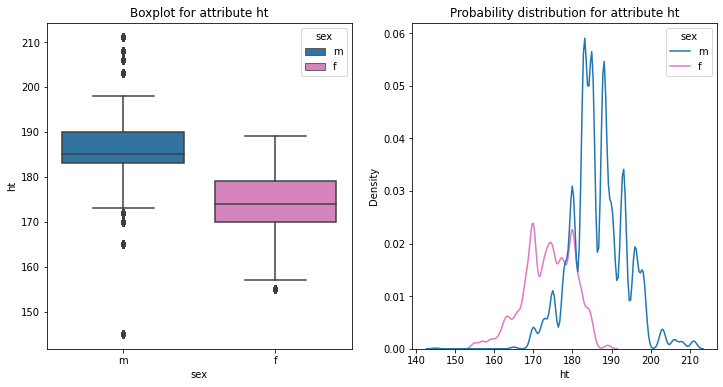

In [48]:
plotby_sex(df_matches, attribute='ht', x='sex', constant=1.5, dodge=False)

In [49]:
df_matches[(df_matches['sex'] == 'm') & (df_matches['ht'] < 160)]['name'].unique()

array(['Ilija Vucic'], dtype=object)

We proceed by updating the height of the player.

In [50]:
df_matches.loc[df_matches['name'] == 'Ilija Vucic', 'ht'] = round(df_matches[df_matches['sex'] == 'm']['ht'].mean())

#### Handling age outliers <a name="handling-age-outliers"></a>

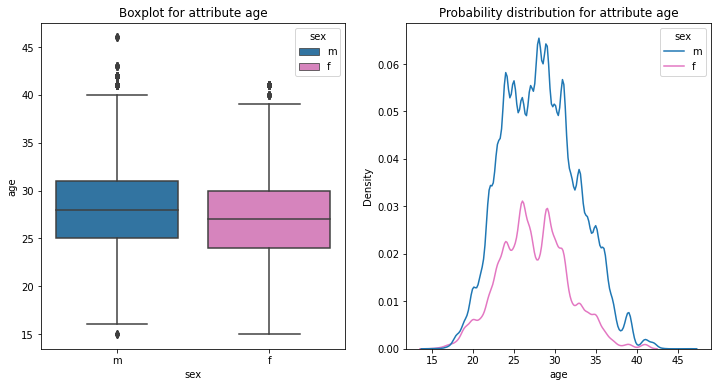

In [51]:
plotby_sex(df_matches, attribute='age', x='sex', dodge=False)

#### Handling minutes outliers <a name="handling-minutes-outliers"></a>

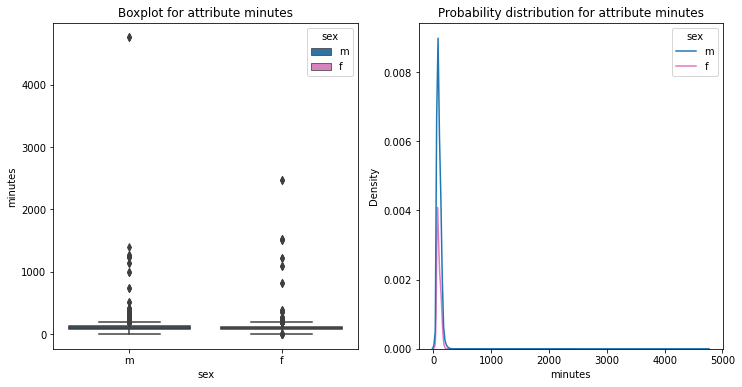

In [52]:
plotby_sex(df_matches, constant=1.5, attribute='minutes', x='sex', dodge=False)

In [53]:
df_matches[(df_matches['minutes'] == 0) & (df_matches['totalGames'] > 0)]

,tourney_name,surface,draw_size,tourney_level,tourney_date,best_of,round,minutes,tourney_spectators,tourney_revenue,...,1stWon,2ndWon,SvGms,bpSaved,bpFaced,rank,rank_points,sets,games,sex
491,Sydney,Hard,32.0,P,2019-01-07,3.0,R32,0.0,3258.0,567644.24,...,43.0,19.0,14.0,6.0,7.0,73.0,800.0,2.0,15.0,f
492,Sydney,Hard,32.0,P,2019-01-07,3.0,R32,0.0,3258.0,567644.24,...,38.0,18.0,14.0,4.0,6.0,26.0,1805.0,1.0,13.0,f
15381,Miami,Hard,128.0,PM,2018-03-19,3.0,Q1,0.0,13375.0,3601609.54,...,9.0,18.0,8.0,4.0,7.0,517.0,59.0,0.0,5.0,f
15382,Miami,Hard,128.0,PM,2018-03-19,3.0,Q1,0.0,13375.0,3601609.54,...,23.0,15.0,9.0,1.0,1.0,88.0,709.0,2.0,12.0,f
24240,Charleston,Clay,64.0,P,2017-04-03,3.0,R32,0.0,4377.0,926105.03,...,17.0,3.0,9.0,1.0,7.0,61.0,925.0,0.0,6.0,f
24241,Charleston,Clay,64.0,P,2017-04-03,3.0,R32,0.0,4377.0,926105.03,...,32.0,7.0,10.0,8.0,11.0,12.0,3810.0,2.0,13.0,f
119349,Adelaide,Hard,32.0,P,2021-02-22,3.0,Q1,0.0,3420.0,660259.04,...,22.0,8.0,8.0,5.0,9.0,208.0,329.0,0.0,4.0,f
119350,Adelaide,Hard,32.0,P,2021-02-22,3.0,Q1,0.0,3420.0,660259.04,...,22.0,11.0,8.0,2.0,2.0,81.0,969.0,2.0,12.0,f
130070,Biella CH,Clay,64.0,C,2019-09-16,3.0,R64,0.0,6661.0,1140571.61,...,25.0,8.0,7.0,4.0,4.0,299.0,135.0,2.0,9.0,m
130071,Biella CH,Clay,64.0,C,2019-09-16,3.0,R64,0.0,6661.0,1140571.61,...,17.0,12.0,7.0,5.0,7.0,408.0,85.0,0.0,5.0,m


We can see that there are some matches that have been played (number of games played is greater than `0`) but have an amount of minutes equal to `0`. For these attributes, we substitute the match length with the mean.

In [54]:
f_cond = (df_matches['sex'] == 'f') & (df_matches['minutes'] == 0) & (df_matches['totalGames'] > 0)
m_cond = (df_matches['sex'] == 'm') & (df_matches['minutes'] == 0) & (df_matches['totalGames'] > 0)

df_matches.loc[f_cond, 'minutes'] = round(df_matches[df_matches['sex'] == 'f']['minutes'].mean(), 0)
df_matches.loc[m_cond, 'minutes'] = round(df_matches[df_matches['sex'] == 'm']['minutes'].mean(), 0)

In [55]:
df_matches[df_matches['minutes'] > 300]

,tourney_name,surface,draw_size,tourney_level,tourney_date,best_of,round,minutes,tourney_spectators,tourney_revenue,...,1stWon,2ndWon,SvGms,bpSaved,bpFaced,rank,rank_points,sets,games,sex
640,Australian Open,Hard,128.0,G,2019-01-14,5.0,R16,305.0,15583.0,2781000.18,...,93.0,34.0,28.0,8.0,14.0,9.0,3750.0,3.0,30.0,m
641,Australian Open,Hard,128.0,G,2019-01-14,5.0,R16,305.0,15583.0,2781000.18,...,95.0,34.0,28.0,15.0,21.0,23.0,1705.0,2.0,29.0,m
3934,Monte Carlo Masters,Clay,64.0,M,2019-04-15,3.0,Q1,510.0,5172.0,1598960.12,...,43.0,23.0,16.0,1.0,5.0,120.0,486.0,2.0,16.0,m
3935,Monte Carlo Masters,Clay,64.0,M,2019-04-15,3.0,Q1,510.0,5172.0,1598960.12,...,47.0,25.0,16.0,8.0,10.0,62.0,850.0,1.0,18.0,m
5322,Roland Garros,Clay,128.0,G,2019-05-27,5.0,R16,309.0,14419.0,1888254.93,...,91.0,40.0,29.0,22.0,27.0,28.0,1365.0,3.0,28.0,m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148684,Guayaquil CH,Clay,32.0,C,2018-10-29,3.0,Q1,4756.0,2579.0,510423.04,...,28.0,6.0,9.0,3.0,4.0,338.0,131.0,2.0,12.0,m
148685,Guayaquil CH,Clay,32.0,C,2018-10-29,3.0,Q1,4756.0,2579.0,510423.04,...,29.0,4.0,10.0,4.0,8.0,698.0,35.0,0.0,7.0,m
158201,Davis Cup G2 R1: PAR vs VEN,Hard,4.0,D,2016-03-04,3.0,RR,344.0,368.0,76623.01,...,14.0,10.0,7.0,0.0,0.0,449.0,91.0,2.0,12.0,m
158519,Davis Cup WG SF: GBR vs ARG,Hard,4.0,D,2016-09-16,5.0,RR,307.0,482.0,85148.55,...,87.0,25.0,27.0,6.0,10.0,64.0,770.0,3.0,29.0,m


There are also some matches that have a duration in minutes too high (considering also the presence of best of 5 matches), for these matches we set an upper bound equal to 300 minutes and drop them.

In [56]:
drop_1dOutliers(df_matches, attribute='minutes', U={'f': 300, 'm': 300}, considerResult=False, approx=True)

[m] U: 300
[m] Number of outliers (>U=300): 48
[f] U: 300
[f] Number of outliers (>U=300): 16


#### Handling totalGames outliers

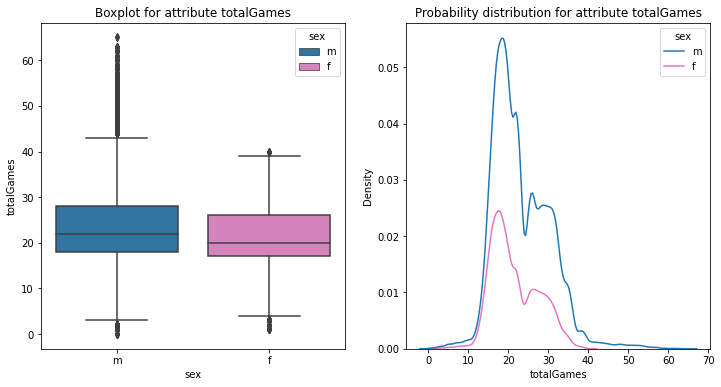

In [57]:
plotby_sex(df_matches, constant=1.5, attribute='totalGames', x='sex', dodge=False)

These outliers are caused by some matches that were played for a lot of sets (best of 5 matches and head-to-head matches where there is an interleaving of set won/lost for each player). In these cases we have decided to not drop them.

#### Handling outliers of number of games

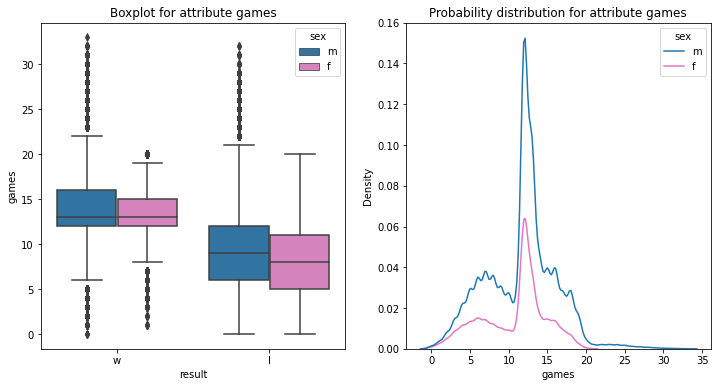

In [58]:
plotby_sex(df_matches, attribute='games', constant=1.5)

As before the higher values of this attribute is due to the fact that there are head-to-head matches.

#### Handling svpt outliers

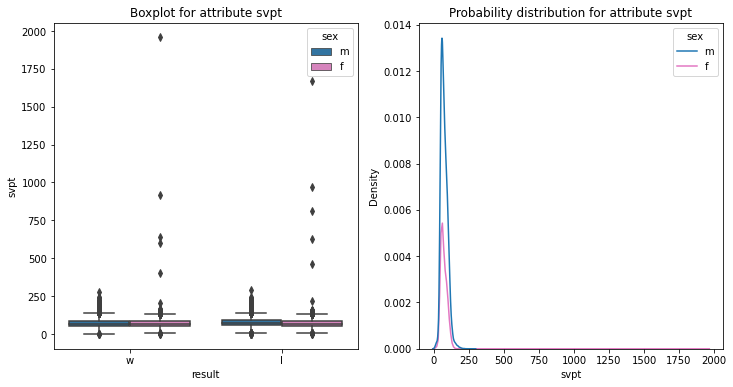

In [59]:
plotby_sex(df_matches, attribute='svpt', constant=1.5)

In [60]:
df_matches[df_matches['svpt'] == 0]

,tourney_name,surface,draw_size,tourney_level,tourney_date,best_of,round,minutes,tourney_spectators,tourney_revenue,...,1stWon,2ndWon,SvGms,bpSaved,bpFaced,rank,rank_points,sets,games,sex
25657,Hobart,Hard,32.0,I,2017-01-09,3.0,R16,5.0,2740.0,507659.53,...,0.0,0.0,0.0,0.0,0.0,127.0,477.0,1.0,1.0,f
56735,Medellin CH,Clay,32.0,C,2016-09-26,3.0,R32,4.0,3933.0,690937.21,...,0.0,0.0,0.0,0.0,0.0,250.0,212.0,1.0,0.0,m
70150,Brescia CH,Hard,32.0,C,2016-11-14,3.0,QF,4.0,3552.0,618422.67,...,0.0,0.0,0.0,0.0,0.0,355.0,131.0,1.0,1.0,m
70249,Istanbul,Clay,32.0,A,2016-04-25,3.0,Q1,7.0,3993.0,804362.52,...,0.0,0.0,0.0,0.0,0.0,257.0,202.0,0.0,0.0,m
77824,Tokyo,Hard,32.0,A,2017-10-02,3.0,R16,8.0,3690.0,582892.45,...,0.0,0.0,0.0,0.0,0.0,40.0,1127.0,1.0,1.0,m
94314,Jinan CH,Hard,32.0,C,2017-08-07,3.0,R32,7.0,3292.0,699278.17,...,0.0,0.0,0.0,0.0,0.0,471.0,81.0,0.0,0.0,m
95908,Fed Cup G1 RR: SRB vs BUL,Hard,2.0,D,2017-02-10,3.0,RR,NaN,254.0,47400.31,...,0.0,0.0,8.0,0.0,0.0,134.0,436.0,0.0,4.0,f
121935,Budapest,Clay,32.0,I,2021-07-12,3.0,R32,200.0,2052.0,317826.53,...,0.0,0.0,0.0,0.0,0.0,334.0,177.0,2.0,19.0,f
121936,Budapest,Clay,32.0,I,2021-07-12,3.0,R32,200.0,2052.0,317826.53,...,0.0,0.0,0.0,0.0,0.0,153.0,509.0,1.0,19.0,f
122876,Cleveland,Hard,32.0,W,2021-08-23,3.0,R32,6.0,3716.0,847358.95,...,0.0,0.0,0.0,0.0,0.0,402.0,132.0,1.0,1.0,f


We can see that there are matches where we do not have serve points (and also the other statistics are equal to 0), so we drop them.

In [61]:
df_matches.drop(df_matches[df_matches['svpt'] == 0].index, inplace=True)

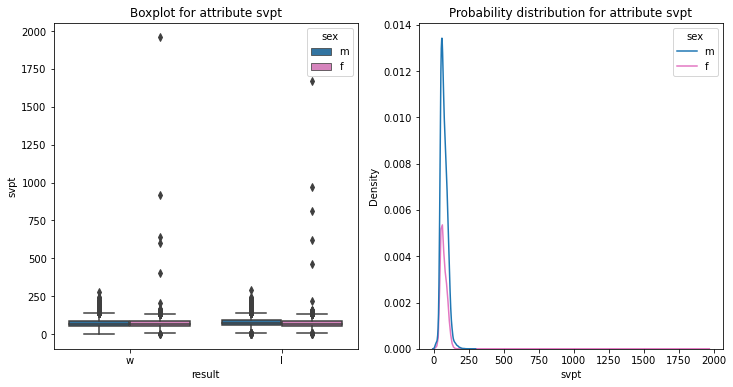

In [62]:
plotby_sex(df_matches, attribute='svpt', constant=1.5)

In [63]:
df_matches[df_matches['svpt'] > 375]

,tourney_name,surface,draw_size,tourney_level,tourney_date,best_of,round,minutes,tourney_spectators,tourney_revenue,...,1stWon,2ndWon,SvGms,bpSaved,bpFaced,rank,rank_points,sets,games,sex
120911,Madrid,Clay,64.0,P,2021-04-29,3.0,Q1,117.0,5888.0,1054197.49,...,836.0,304.0,12.0,209.0,266.0,65.0,1253.0,2.0,14.0,f
120912,Madrid,Clay,64.0,P,2021-04-29,3.0,Q1,117.0,5888.0,1054197.49,...,532.0,399.0,13.0,114.0,190.0,147.0,544.0,1.0,12.0,f
120951,Rome,Clay,64.0,PM,2021-05-10,3.0,QF,100.0,7490.0,1595530.68,...,220.0,160.0,11.0,40.0,70.0,25.0,2335.0,2.0,13.0,f
120952,Rome,Clay,64.0,PM,2021-05-10,3.0,QF,100.0,7490.0,1595530.68,...,250.0,200.0,11.0,120.0,170.0,31.0,2058.0,0.0,9.0,f
121303,Strasbourg,Clay,32.0,W,2021-05-24,3.0,R16,72.0,3012.0,543587.01,...,320.0,56.0,11.0,32.0,48.0,46.0,1618.0,0.0,10.0,f
121304,Strasbourg,Clay,32.0,W,2021-05-24,3.0,R16,72.0,3012.0,543587.01,...,280.0,112.0,11.0,16.0,24.0,216.0,322.0,2.0,13.0,f
121428,Nottingham,Grass,64.0,I,2021-06-07,3.0,R32,162.0,7378.0,951132.22,...,196.0,48.0,16.0,16.0,36.0,28.0,2222.0,2.0,17.0,f
121429,Nottingham,Grass,64.0,I,2021-06-07,3.0,R32,162.0,7378.0,951132.22,...,204.0,68.0,17.0,40.0,60.0,145.0,564.0,1.0,17.0,f
122131,Gdynia,Clay,32.0,I,2021-07-19,3.0,QF,160.0,3671.0,623848.55,...,351.0,90.0,15.0,108.0,180.0,141.0,557.0,2.0,18.0,f
122132,Gdynia,Clay,32.0,I,2021-07-19,3.0,QF,160.0,3671.0,623848.55,...,369.0,45.0,16.0,81.0,180.0,143.0,557.0,1.0,13.0,f


There are a lot of matches that have an high number of service points, considering that these matches have also a duration that is not high then we can assume that these are outliers. We set a threshold of 375 service points and drop all the matches with a greater amount.

In [64]:
drop_1dOutliers(df_matches, attribute='svpt', approx=True, U={'ml': 375, 'fl': 375, 'mw': 375, 'fw': 375})

[m, w] U: 375
[m, w] Number of outliers (>U=375): 0
[m, l] U: 375
[m, l] Number of outliers (>U=375): 0
[f, w] U: 375
[f, w] Number of outliers (>U=375): 5
[f, l] U: 375
[f, l] Number of outliers (>U=375): 5


#### Other attributes

<AxesSubplot:xlabel='result', ylabel='1stIn'>

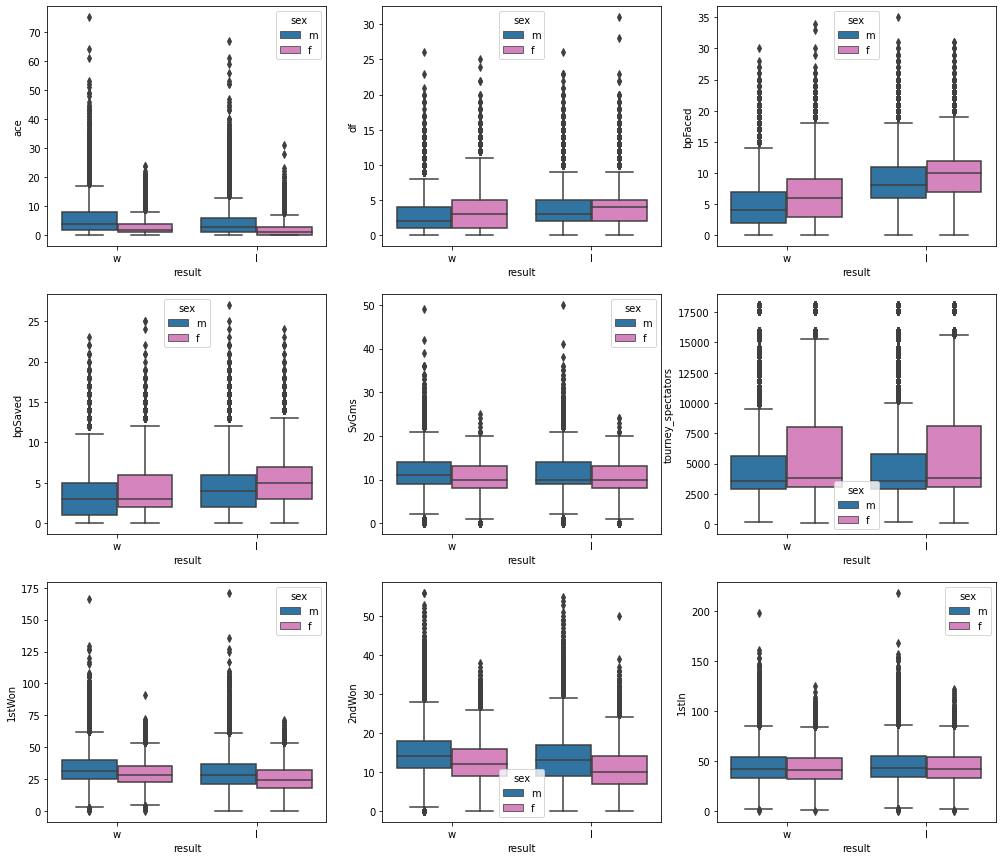

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17, 15))

sns.boxplot(x='result', y='ace', data=df_matches, orient='v', ax=axes[0][0], hue='sex', palette=['tab:blue', 'tab:pink'], dodge=True)
sns.boxplot(x='result', y='df', data=df_matches, orient='v', ax=axes[0][1], hue='sex', palette=['tab:blue', 'tab:pink'], dodge=True)
sns.boxplot(x='result', y='bpFaced', data=df_matches, orient='v', ax=axes[0][2], hue='sex', palette=['tab:blue', 'tab:pink'], dodge=True)
sns.boxplot(x='result', y='bpSaved', data=df_matches, orient='v', ax=axes[1][0], hue='sex', palette=['tab:blue', 'tab:pink'], dodge=True)
sns.boxplot(x='result', y='SvGms', data=df_matches, orient='v', ax=axes[1][1], hue='sex', palette=['tab:blue', 'tab:pink'], dodge=True)
sns.boxplot(x='result', y='tourney_spectators', data=df_matches, orient='v', ax=axes[1][2], hue='sex', palette=['tab:blue', 'tab:pink'], dodge=True)
sns.boxplot(x='result', y='1stWon', data=df_matches, orient='v', ax=axes[2][0], hue='sex', palette=['tab:blue', 'tab:pink'], dodge=True)
sns.boxplot(x='result', y='2ndWon', data=df_matches, orient='v', ax=axes[2][1], hue='sex', palette=['tab:blue', 'tab:pink'], dodge=True)
sns.boxplot(x='result', y='1stIn', data=df_matches, orient='v', ax=axes[2][2], hue='sex', palette=['tab:blue', 'tab:pink'], dodge=True)

For all these other attributes, we have decided to not drop/modify the outliers to not disrupt the possible patterns that will allow us to have better defined and separated cluster between strong and poor players.

## Analyzing the correlation<a name="analyzing-correlation"></a>

Next we analyze the correlation among the attributes of our dataset, we use a heatmap matrix to visualize better which are the features that are highly correlated.

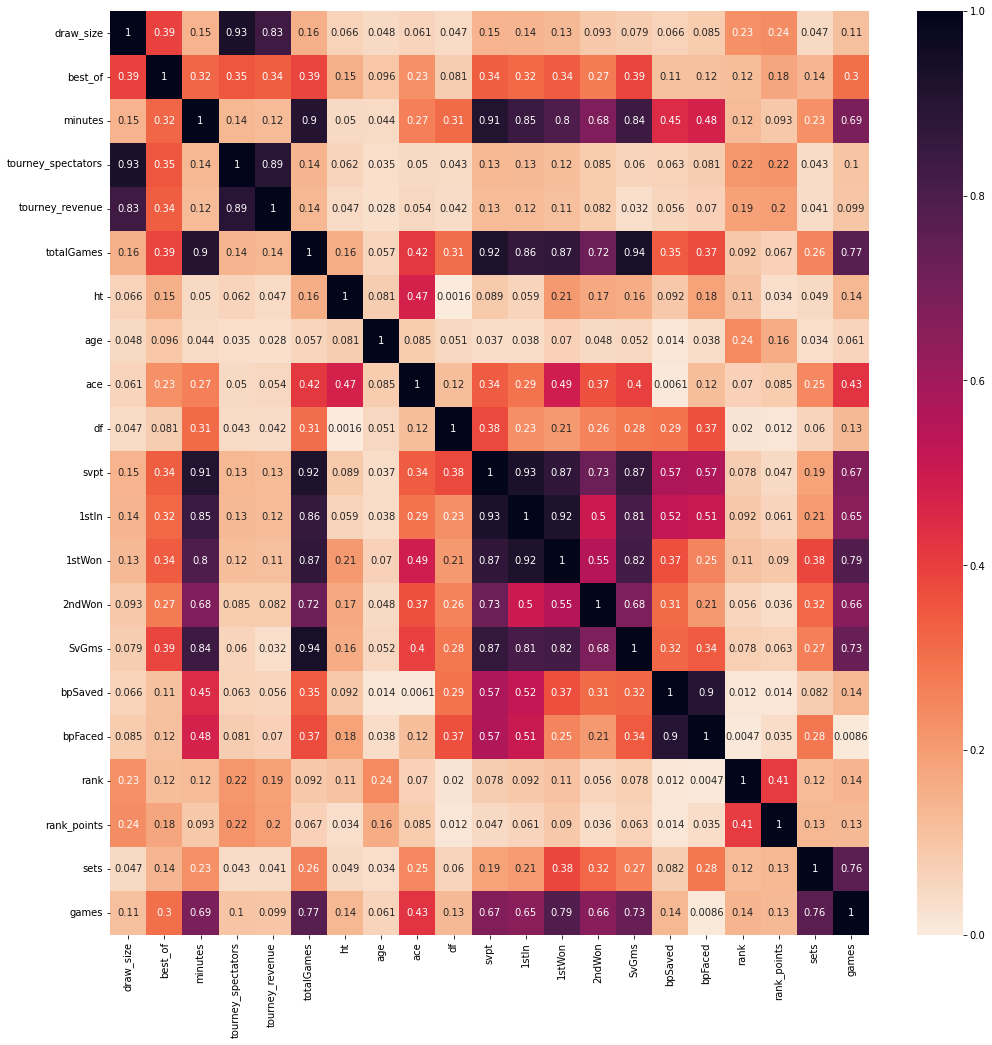

In [66]:
plt.figure(figsize=(17, 17))
cmap = sns.cm.rocket_r
sns.heatmap(df_matches.corr().abs(), vmin=0, vmax=1, annot=True, cmap=cmap);

We use a scatter plot to visualize the pairs of features that are highly correlated, e.g. `tourney_spectators` and `tourney_revenue` have a high correlation because they somehow represents the same information, which is the affluence of people for that tournament.

<AxesSubplot:xlabel='tourney_spectators', ylabel='tourney_revenue'>

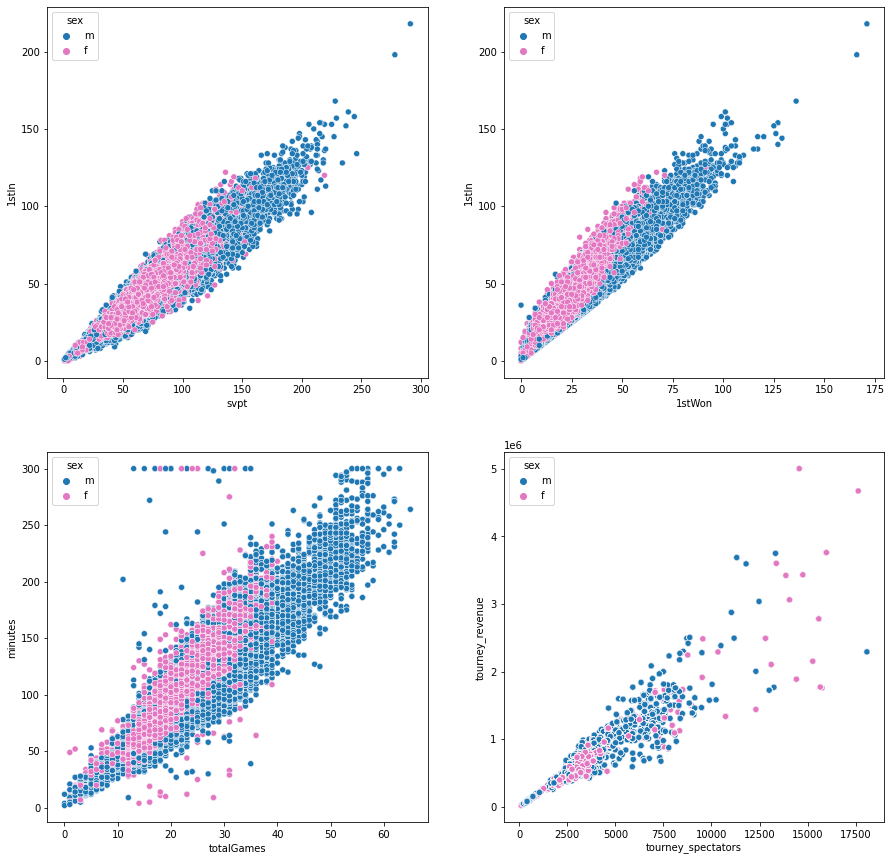

In [67]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

sns.scatterplot(x="svpt", y='1stIn', ax=axes[0][0], data=df_matches, hue="sex", palette=['tab:blue', 'tab:pink'])
sns.scatterplot(x="1stWon", y='1stIn', ax=axes[0][1], data=df_matches, hue="sex", palette=['tab:blue', 'tab:pink'])
sns.scatterplot(x="totalGames", y='minutes', ax=axes[1][0], data=df_matches, hue="sex", palette=['tab:blue', 'tab:pink'])
sns.scatterplot(x="tourney_spectators", y='tourney_revenue', ax=axes[1][1], data=df_matches, hue="sex", palette=['tab:blue', 'tab:pink'])

We drop features that have high correlation between them and keep those which are more interesting/significant for the task.

In [68]:
#we just keep the rank of the players and drop the rank points
df_matches = df_matches.drop(labels='rank_points', axis=1)

# tourney spectators is more interesting for the players
correlation = df_matches['tourney_spectators'].corr(df_matches['tourney_revenue'])
print(f"Correlation between tourney_spectators and tourney_revenue: {correlation}")
df_matches = df_matches.drop(labels='tourney_revenue', axis=1)

# drop draw_size
correlation = df_matches['draw_size'].corr(df_matches['tourney_spectators'])
print(f"Correlation between tourney_spectators and draw_size: {correlation}")
df_matches = df_matches.drop(labels='draw_size', axis=1)

Correlation between tourney_spectators and tourney_revenue: 0.8926597752042945
Correlation between tourney_spectators and draw_size: 0.931839533822453


In [69]:
c = df_matches.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)
print(so[10:50])

2ndWon              2ndWon                1.000000
SvGms               SvGms                 1.000000
bpSaved             bpSaved               1.000000
bpFaced             bpFaced               1.000000
rank                rank                  1.000000
sets                sets                  1.000000
tourney_spectators  tourney_spectators    1.000000
games               games                 1.000000
totalGames          SvGms                 0.935054
SvGms               totalGames            0.935054
1stIn               svpt                  0.929046
svpt                1stIn                 0.929046
                    totalGames            0.921685
totalGames          svpt                  0.921685
1stIn               1stWon                0.918387
1stWon              1stIn                 0.918387
svpt                minutes               0.906746
minutes             svpt                  0.906746
totalGames          minutes               0.902897
minutes             totalGames 

## Handling missing values <a name="handling-missing-values"></a>


Let's check if other attributes have missing values

In [70]:
df_matches.isnull().any()

tourney_name           True
surface                True
tourney_level          True
tourney_date           True
best_of                True
round                  True
minutes                True
tourney_spectators     True
totalGames             True
result                False
entry                  True
name                  False
hand                   True
ht                     True
ioc                    True
age                    True
ace                    True
df                     True
svpt                   True
1stIn                  True
1stWon                 True
2ndWon                 True
SvGms                  True
bpSaved                True
bpFaced                True
rank                   True
sets                   True
games                  True
sex                   False
dtype: bool

Next we check how many missing values we have for the dataset

In [71]:
df_matches.isna().sum() / df_matches.shape[0] * 100

tourney_name           0.003752
surface                0.096937
tourney_level          0.005003
tourney_date           0.003752
best_of                0.006254
round                  0.007505
minutes                0.973746
tourney_spectators     0.005003
totalGames             0.006254
result                 0.000000
entry                 83.066705
name                   0.000000
hand                   0.026892
ht                    50.570364
ioc                    0.004378
age                    0.011883
ace                    0.005003
df                     0.005629
svpt                   0.006254
1stIn                  0.007505
1stWon                 0.006254
2ndWon                 0.009381
SvGms                  0.005003
bpSaved                0.006879
bpFaced                0.009381
rank                   1.300204
sets                   0.006254
games                  0.006254
sex                    0.000000
dtype: float64

We fix the missing values using various techniques such as: using the central tendency, the distribution probability for the attribute, interpolation or ad-hoc solutions.

In [72]:
df_matches.reset_index(drop=True, inplace=True) 



### Handling missing values for the tournament<a name="handling-na-tourney"></a>

We start by replacing values for attributes relative to the tournament, such as: `tourney_name`, `tourney_date`, `tourney_level`, `tourney_spectators` missing values with the correct one (we use the values from the previous match).

In [73]:
def replace_nan_tourney(attribute):
    print('BEFORE REPLACING')
    nan_attr_rows = df_matches.index[df_matches[attribute].isna()].tolist() #indices of missing values from the attribute
    print('Rows with missing values for '+attribute+': '+str(len(nan_attr_rows)))
    for idx in nan_attr_rows:
        df_matches.loc[idx,attribute] = df_matches.loc[idx-1, attribute] #substitute the attribute with the one from previous match (matches from the same tournament are contiguous)
    print('AFTER REPLACING')
    print('Rows with missing values for '+attribute+' '+str(df_matches[df_matches[attribute].isna()].shape[0]))
    print('-------------------')

replace_nan_tourney('tourney_name')
replace_nan_tourney('tourney_date')
replace_nan_tourney('tourney_level')
replace_nan_tourney('tourney_spectators')



BEFORE REPLACING
Rows with missing values for tourney_name: 6
AFTER REPLACING
Rows with missing values for tourney_name 0
-------------------
BEFORE REPLACING
Rows with missing values for tourney_date: 6
AFTER REPLACING
Rows with missing values for tourney_date 0
-------------------
BEFORE REPLACING
Rows with missing values for tourney_level: 8
AFTER REPLACING
Rows with missing values for tourney_level 0
-------------------
BEFORE REPLACING
Rows with missing values for tourney_spectators: 8
AFTER REPLACING
Rows with missing values for tourney_spectators 0
-------------------


### Handling missing values which have default values<a name="handling-na-default"></a>

The attributes `entry` has the default `D` which stands for 'Default', i.e. the entry is standard and not a special one.

In [74]:
print('BEFORE REPLACING')
print('Number of rows with missing values for entry: '+str(df_matches['entry'].isna().sum()))
df_matches['entry'].fillna(value='D', inplace=True)
print('AFTER REPLACING')
print('Number of rows with missing values for entry: '+str(df_matches['entry'].isna().sum()))

BEFORE REPLACING
Number of rows with missing values for entry: 132822
AFTER REPLACING
Number of rows with missing values for entry: 0


### Handling missing values for static attributes <a name="handling-na-static"></a>

We try to replaced missing values by observing other instance with the same static values, e.g. the nationality and the hand used during the match which remain the same.

In [75]:
print('BEFORE REPLACING')
print('Number of rows with missing values for hand: '+str(df_matches.loc[df_matches['hand'].isna()].shape[0]))
nan_hand_rows = df_matches.index[df_matches['hand'].isna()]
for idx in nan_hand_rows: 
    name = df_matches.iloc[idx]['name']
    hand_arr = df_matches.loc[(df_matches['name'] == name) & (df_matches['hand'].notna()), 'hand'].unique()
    if len(hand_arr) == 1:
        hand = hand_arr[0]
        df_matches.loc[idx,'hand'] = hand
print('AFTER REPLACING')
print('Number of rows with missing values for hand: '+str(df_matches.loc[df_matches['hand'].isna()].shape[0]))
print('----------------')

print('BEFORE REPLACING')
print('Number of rows with missing values for ioc: '+str(df_matches.loc[df_matches['ioc'].isna()].shape[0]))
nan_ioc_rows = df_matches.index[df_matches['ioc'].isna()]
for idx in nan_ioc_rows: 
    name = df_matches.iloc[idx]['name']
    ioc_arr = df_matches.loc[(df_matches['name'] == name) & (df_matches['ioc'].notna()), 'ioc'].unique()
    if len(ioc_arr) == 1:
        ioc = ioc_arr[0]
        df_matches.loc[idx,'ioc'] = ioc
print('AFTER REPLACING')
print('Number of rows with missing values for ioc: '+str(df_matches.loc[df_matches['ioc'].isna()].shape[0]))

BEFORE REPLACING
Number of rows with missing values for hand: 43
AFTER REPLACING
Number of rows with missing values for hand: 30
----------------
BEFORE REPLACING
Number of rows with missing values for ioc: 7
AFTER REPLACING
Number of rows with missing values for ioc: 0


We use an external source for the tennis players in ATP and WTA to fill the missing values left about `ioc`, `hand` and `ht` and `rank`.

In [76]:
df_atp_players = pd.read_csv('./data/updated_players.csv', sep=',')
df_atp_rank = pd.read_csv('./data/atp_rankings_current.csv', sep=',')
df_wta_players = pd.read_csv('./data/wta_players.csv', sep=',')
df_wta_rank = pd.read_csv('./data/wta_rankings_current.csv', sep=',')

In [77]:
df_matches.isna().sum()

tourney_name              0
surface                 155
tourney_level             0
tourney_date              0
best_of                  10
round                    12
minutes                1557
tourney_spectators        0
totalGames               10
result                    0
entry                     0
name                      0
hand                     30
ht                    80861
ioc                       0
age                      19
ace                       8
df                        9
svpt                     10
1stIn                    12
1stWon                   10
2ndWon                   15
SvGms                     8
bpSaved                  11
bpFaced                  15
rank                   2079
sets                     10
games                    10
sex                       0
dtype: int64

In [78]:
df_atp_unfd_players = df_atp_players.join(df_atp_rank.set_index(['player']), on=['player_id'], how='inner')
df_atp_unfd_players.head()

,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id,ranking_date,rank,points
643,100644,Alexander,Zverev,R,19970420,GER,198.0,Q4189526,20210104,7,5615
643,100644,Alexander,Zverev,R,19970420,GER,198.0,Q4189526,20210111,7,5615
643,100644,Alexander,Zverev,R,19970420,GER,198.0,Q4189526,20210118,7,5615
643,100644,Alexander,Zverev,R,19970420,GER,198.0,Q4189526,20210125,7,5615
643,100644,Alexander,Zverev,R,19970420,GER,198.0,Q4189526,20210201,7,5615


In [79]:
df_wta_unfd_players = df_wta_players.join(df_wta_rank.set_index(['player']), on=['player_id'], how='inner')
df_wta_unfd_players.head()

,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id,ranking_date,rank,points,tours
34,200033,Serena,Williams,R,19810926.0,USA,175.0,Q11459,20210104,11,4080,13
34,200033,Serena,Williams,R,19810926.0,USA,175.0,Q11459,20210111,11,4080,13
34,200033,Serena,Williams,R,19810926.0,USA,175.0,Q11459,20210118,11,4080,13
34,200033,Serena,Williams,R,19810926.0,USA,175.0,Q11459,20210125,11,4080,13
34,200033,Serena,Williams,R,19810926.0,USA,175.0,Q11459,20210201,11,4080,13


In [80]:
df_atp_unfd_players.drop(df_atp_unfd_players[df_atp_unfd_players['rank'].isna()].index, inplace=True)
df_wta_unfd_players.drop(df_wta_unfd_players[df_wta_unfd_players['rank'].isna()].index, inplace=True)

In [81]:

df_atp_unfd_players = df_atp_unfd_players[df_atp_unfd_players['ranking_date'] == 20211025] #keep ranking updated until 25 Oct
df_wta_unfd_players = df_wta_unfd_players[df_wta_unfd_players['ranking_date'] == 20211025] #keep ranking updated until 25 Oct

In [82]:
df_atp_unfd_players = df_atp_unfd_players.drop(['player_id','dob', 'wikidata_id', 'ranking_date', 'points'], axis=1)
df_wta_unfd_players = df_wta_unfd_players.drop(['player_id','dob', 'wikidata_id', 'ranking_date', 'points'], axis=1)
df_atp_unfd_players['rank'] = df_atp_unfd_players['rank'].astype(np.float64)
df_wta_unfd_players['rank'] = df_wta_unfd_players['rank'].astype(np.float64)


In [83]:
df_wta_unfd_players


,name_first,name_last,hand,ioc,height,rank,tours
34,Serena,Williams,R,USA,175.0,41.0,10
80,Kim,Clijsters,R,BEL,175.0,1103.0,4
749,Venus,Williams,R,USA,185.0,173.0,13
1319,Bethanie,Mattek Sands,R,USA,168.0,351.0,9
1321,Svetlana,Kuznetsova,R,RUS,174.0,104.0,12
...,...,...,...,...,...,...,...
39445,Chelsea,Fontenel,U,SUI,NaN,1365.0,3
39482,Paris,Corley,U,USA,NaN,1237.0,3
41707,Johanne Christine,Svendsen,U,DEN,NaN,1133.0,2
45084,Lavinia,Tanasie,U,ROU,NaN,1187.0,2


In [84]:
df_atp_unfd_players['name'] = df_atp_unfd_players['name_first'] + " " + df_atp_unfd_players['name_last']
df_atp_unfd_players['ht'] = df_atp_unfd_players['height']
df_atp_unfd_players = df_atp_unfd_players.drop(['height','name_first', 'name_last'] , axis=1)
print(df_atp_unfd_players.head())
df_wta_unfd_players['name'] = df_wta_unfd_players['name_first'] + " " + df_wta_unfd_players['name_last']
df_wta_unfd_players['ht'] = df_wta_unfd_players['height']
df_wta_unfd_players = df_wta_unfd_players.drop(['height','name_first', 'name_last','tours'] , axis=1)


     hand  ioc    rank              name     ht
643     R  GER     4.0  Alexander Zverev  198.0
2092    L  USA   580.0       Martin Damm    NaN
3174    R  JPN   983.0  Toshihide Matsui  180.0
3219    R  KOR  1429.0       Oh Hee Kwon    NaN
3332    R  CRO   231.0      Ivo Karlovic  208.0


In [85]:
ids = df_atp_unfd_players["name"]
df_atp_unfd_players[ids.isin(ids[ids.duplicated()])]
df_atp_unfd_players = df_atp_unfd_players.drop([51938,53176, 53181])

In [86]:
#df_matches.join(df_atp_unfd_players, on=['name'], how='left')
#df_matches.join(df_wta_unfd_players, on=['name'], how='left')
df_matches = df_matches.set_index(['name'], drop=False)
df_matches.update(df_atp_unfd_players.set_index(['name']), overwrite=True)
df_matches.update(df_wta_unfd_players.set_index(['name']), overwrite=True)
df_matches = df_matches.reset_index(drop=True)

For some attribute such as `rank` some players may not have this value (e.g. they have not participated in one of the major 19 tournaments)

In [87]:
print('BEFORE REPLACING')
print('Number of rows with missing values for rank: '+str(df_matches['rank'].isna().sum()))
df_matches['rank'].fillna(-1, inplace=True)
print('AFTER REPLACING')
print('Number of rows with missing values for rank: '+str(df_matches['rank'].isna().sum()))

BEFORE REPLACING
Number of rows with missing values for rank: 1026
AFTER REPLACING
Number of rows with missing values for rank: 0


In [88]:
df_matches.isna().sum()

tourney_name              0
surface                 155
tourney_level             0
tourney_date              0
best_of                  10
round                    12
minutes                1557
tourney_spectators        0
totalGames               10
result                    0
entry                     0
name                      0
hand                     23
ht                    80815
ioc                       0
age                      19
ace                       8
df                        9
svpt                     10
1stIn                    12
1stWon                   10
2ndWon                   15
SvGms                     8
bpSaved                  11
bpFaced                  15
rank                      0
sets                     10
games                    10
sex                       0
dtype: int64

### Handling of missing values using central tendency<a name="handling-na-central"></a>

We replace missing values for the attributes `surface`, `round`, `hand`, `sets` and `games`

In [89]:
def replace_with_mode(attribute):

    print('Missing values for the attribute '+attribute+' before replacing: '+str(df_matches[attribute].isna().sum()))
    df_matches[attribute].fillna(df_matches[attribute].mode()[0], inplace=True) 
    print('Missing values for the attribute '+attribute+' after replacing: '+str(df_matches[attribute].isna().sum())) 
    print('--------------------------')
    
replace_with_mode('surface')

replace_with_mode('round')

replace_with_mode('hand')

replace_with_mode('sets')

replace_with_mode('games')

replace_with_mode('totalGames')

Missing values for the attribute surface before replacing: 155
Missing values for the attribute surface after replacing: 0
--------------------------
Missing values for the attribute round before replacing: 12
Missing values for the attribute round after replacing: 0
--------------------------
Missing values for the attribute hand before replacing: 23
Missing values for the attribute hand after replacing: 0
--------------------------
Missing values for the attribute sets before replacing: 10
Missing values for the attribute sets after replacing: 0
--------------------------
Missing values for the attribute games before replacing: 10
Missing values for the attribute games after replacing: 0
--------------------------
Missing values for the attribute totalGames before replacing: 10
Missing values for the attribute totalGames after replacing: 0
--------------------------


In [90]:
mean_ht_men = round(df_matches[df_matches['sex'] == 'm']['ht'].mean(), 2) #mean height among male players
mean_ht_women = round(df_matches[df_matches['sex'] == 'f']['ht'].mean(), 2) #mean height among female players
mean_age_men = round(df_matches[df_matches['sex'] == 'm']['age'].mean(), 0) #mean age among male players
mean_age_women = round(df_matches[df_matches['sex'] == 'f']['age'].mean(), 0) #mean age among female players

print('BEFORE REPLACING')
print('Number of missing values for men height: '+str(df_matches.loc[(df_matches['sex'] == 'm') & (df_matches['ht'].isna()), 'ht'].shape[0]))
print('Number of missing values for women height: '+str(df_matches.loc[(df_matches['sex'] == 'f') & (df_matches['ht'].isna()), 'ht'].shape[0]))
print('Number of missing values for men age: '+str(df_matches.loc[(df_matches['sex'] == 'm') & (df_matches['age'].isna()), 'age'].shape[0]))
print('Number of missing values for women age: '+str(df_matches.loc[(df_matches['sex'] == 'f') & (df_matches['age'].isna()), 'age'].shape[0]))
df_matches.loc[(df_matches['sex'] == 'm') & (df_matches['ht'].isna()), 'ht'] = mean_ht_men
df_matches.loc[(df_matches['sex'] == 'f') & (df_matches['ht'].isna()), 'ht'] = mean_ht_women
df_matches.loc[(df_matches['sex'] == 'm') & (df_matches['age'].isna()), 'age'] = mean_age_men
df_matches.loc[(df_matches['sex'] == 'f') & (df_matches['age'].isna()), 'age'] = mean_age_women
print('---------------')
print('AFTER REPLACING')
print('Number of missing values for men height: '+str(df_matches.loc[(df_matches['sex'] == 'm') & (df_matches['ht'].isna()), 'ht'].shape[0]))
print('Number of missing values for women height: '+str(df_matches.loc[(df_matches['sex'] == 'f') & (df_matches['ht'].isna()), 'ht'].shape[0]))
print('Number of missing values for men age: '+str(df_matches.loc[(df_matches['sex'] == 'm') & (df_matches['age'].isna()), 'age'].shape[0]))
print('Number of missing values for women age: '+str(df_matches.loc[(df_matches['sex'] == 'f') & (df_matches['age'].isna()), 'age'].shape[0]))

BEFORE REPLACING
Number of missing values for men height: 62715
Number of missing values for women height: 18100
Number of missing values for men age: 12
Number of missing values for women age: 7
---------------
AFTER REPLACING
Number of missing values for men height: 0
Number of missing values for women height: 0
Number of missing values for men age: 0
Number of missing values for women age: 0


### Using interpolation to fill missing values<a name="handling-na-interpolation"></a>

We analyze the distribution, the descriptive statistics and scatter plot of minutes to establish what kind of interpolation is the better one to estimate the missing values.

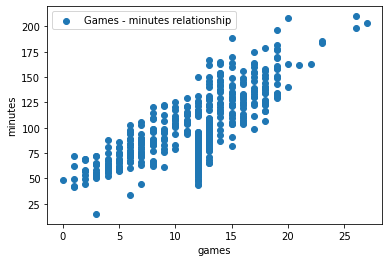

In [91]:
plt.scatter(df_matches['games'].sample(n=500, random_state=10), df_matches['minutes'].sample(n=500, random_state=10), label='Games - minutes relationship')
plt.xlabel('games')
plt.ylabel('minutes')
plt.legend()
plt.show()

In [92]:
df_matches['minutes'].describe()

count    158341.000000
mean         98.096823
std          34.467466
min           2.000000
25%          72.000000
50%          92.000000
75%         120.000000
max         300.000000
Name: minutes, dtype: float64

We use linear interpolation, interpolation using k-nn, polynomial interpolation of the second order and the data imputation with mean and mode substitution.

##### Minutes

In [93]:
df_matches_linear= df_matches['minutes'].interpolate(method='linear')
df_matches_nn= df_matches['minutes'].interpolate(method='nearest')
df_matches_pol_2= df_matches['minutes'].interpolate(method='polynomial', order=2)
df_matches_mean = df_matches['minutes'].fillna(df_matches['minutes'].mean())
df_matches_mode = df_matches['minutes'].fillna(df_matches['minutes'].mode()[0])

We observe the various distribution after the interpolation of substitution through the central tendency, we will use the linear interpolation which mantains a similar normal distribution.

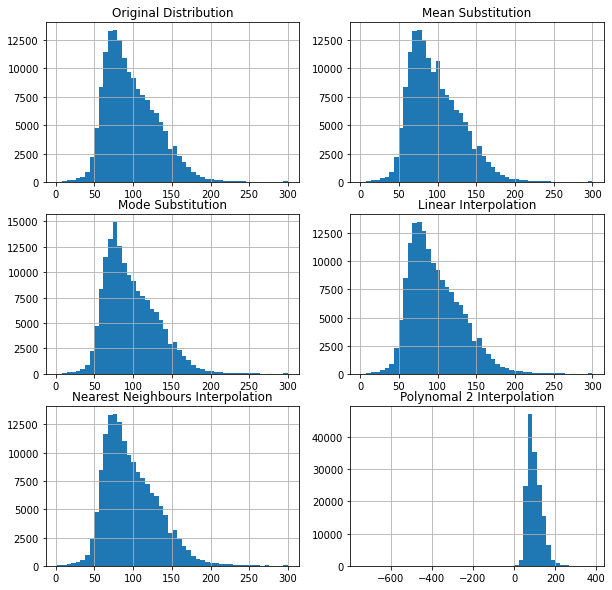

In [94]:
def plot_distr_interpolation(attribute, n_bins=10):
    fig = plt.figure(figsize=(10, 10)) 
    fig_dims = (3, 2)

    # Original Distribution
    plt.subplot2grid(fig_dims, (0, 0))
    fig1 = df_matches[attribute].hist(bins=n_bins)
    fig1.title.set_text('Original Distribution')

    # Plot Mean
    plt.subplot2grid(fig_dims, (0, 1))
    fig2 = df_matches_mean.hist(bins=n_bins)
    fig2.title.set_text('Mean Substitution')

    # Plot Mode
    plt.subplot2grid(fig_dims, (1, 0))
    fig3 = df_matches_mode.hist(bins=n_bins)
    fig3.title.set_text('Mode Substitution')

    # Plot Linear Interpolation
    plt.subplot2grid(fig_dims, (1, 1))
    fig4 = df_matches_linear.hist(bins=n_bins)
    fig4.title.set_text('Linear Interpolation')

    # Plot NN
    plt.subplot2grid(fig_dims, (2, 0))
    fig5 = df_matches_nn.hist(bins=n_bins)
    fig5.title.set_text('Nearest Neighbours Interpolation')

    # Plot Polynomial order 2
    plt.subplot2grid(fig_dims, (2, 1))
    fig6 = df_matches_pol_2.hist(bins=n_bins)
    fig6.title.set_text('Polynomal 2 Interpolation')

    plt.show()

plot_distr_interpolation('minutes', 50)


In [95]:
print(df_matches['minutes'].describe())
print("---------------")
print(df_matches_linear.describe())

count    158341.000000
mean         98.096823
std          34.467466
min           2.000000
25%          72.000000
50%          92.000000
75%         120.000000
max         300.000000
Name: minutes, dtype: float64
---------------
count    159898.000000
mean         98.040826
std          34.423392
min           2.000000
25%          72.000000
50%          92.000000
75%         120.000000
max         300.000000
Name: minutes, dtype: float64


We can notice that statistics about the attribute did not change radically, so the linear interpolation has given likely estimates of the missing values on a global scale. We will consider the interpolation on data segmentation performed on the sex of the players.

In [96]:
inter_df = df_matches.copy()
inter_df['minutes'] = df_matches['minutes'].interpolate(method='linear').round()


In [97]:
def print_stats_change(attribute, orig_df, interpolated_df):
    mean_change = abs(interpolated_df[attribute].mean() - orig_df[attribute].mean())/orig_df[attribute].mean()*100 if orig_df[attribute].mean() != 0 else 0
    std_change = abs(interpolated_df[attribute].std() - orig_df[attribute].std())/orig_df[attribute].std()*100 if orig_df[attribute].std() != 0 else 0
    print("The mean of "+attribute+" has changed of "+str(mean_change)+" %")
    print("The std of "+attribute+" has changed of "+str(std_change)+" %")

In [98]:
print_stats_change("minutes", df_matches, inter_df)

The mean of minutes has changed of 0.05707666982104479 %
The std of minutes has changed of 0.12782475116889122 %


In [99]:
old_na = df_matches.isna().sum()['minutes']
df_matches = inter_df.copy()
print(f"A total of {old_na} missing values have been filled with linear interpolation")

A total of 1557 missing values have been filled with linear interpolation


We proceed in the same way for the attributes `ace`, `df`, `1stIn`, `bpFaced`,`1svWon`, `2svWon`, `bpS_bpF`

##### Ace

In [100]:
df_matches_linear= df_matches['ace'].interpolate(method='linear') #TODO
df_matches_nn= df_matches['ace'].interpolate(method='nearest')
df_matches_pol_2= df_matches['ace'].interpolate(method='polynomial', order=2)
df_matches_mean = df_matches['ace'].fillna(df_matches['ace'].mean())
df_matches_mode = df_matches['ace'].fillna(df_matches['ace'].mode()[0])

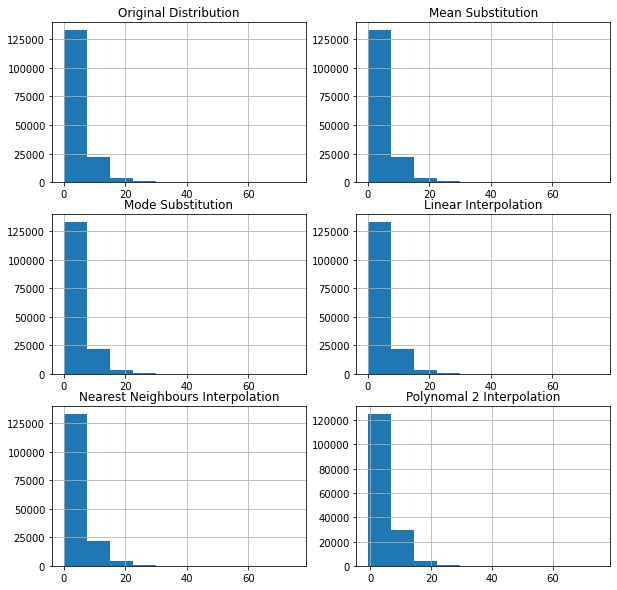

In [101]:
plot_distr_interpolation('ace')

In [102]:
print(df_matches['ace'].describe())
print("---------------")
print(df_matches_linear.describe())

count    159890.000000
mean          4.235424
std           4.182529
min           0.000000
25%           1.000000
50%           3.000000
75%           6.000000
max          75.000000
Name: ace, dtype: float64
---------------
count    159898.000000
mean          4.235503
std           4.182523
min           0.000000
25%           1.000000
50%           3.000000
75%           6.000000
max          75.000000
Name: ace, dtype: float64


We select the linear interpolation since it gives the best estimation for the missing values.

In [103]:
inter_df['ace'] = df_matches['ace'].interpolate(method='linear').round()

In [104]:
print_stats_change("ace", df_matches, inter_df)

The mean of ace has changed of 0.0020844443586449097 %
The std of ace has changed of 5.291379693104237e-05 %


In [105]:
old_na = df_matches.isna().sum()['ace']
df_matches = inter_df.copy()
print(f"A total of {old_na} missing values have been filled with linear interpolation")

A total of 8 missing values have been filled with linear interpolation


##### Double Faults

In [106]:
df_matches_linear= df_matches['df'].interpolate(method='linear')
df_matches_nn= df_matches['df'].interpolate(method='nearest')
df_matches_pol_2= df_matches['df'].interpolate(method='polynomial', order=2)
df_matches_mean = df_matches['df'].fillna(df_matches['df'].mean())
df_matches_mode = df_matches['df'].fillna(df_matches['df'].mode()[0])

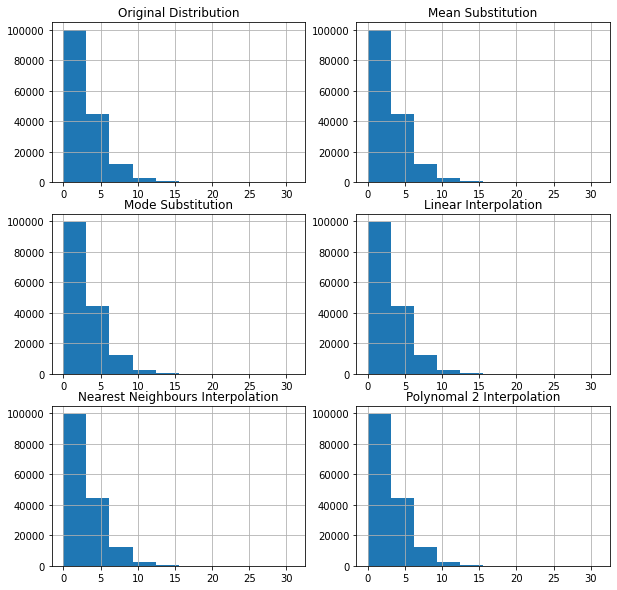

In [107]:
plot_distr_interpolation('df')

In [108]:
print(df_matches['df'].describe())
print("-------------")
print(df_matches_linear.describe())

count    159889.000000
mean          3.211109
std           2.486238
min           0.000000
25%           1.000000
50%           3.000000
75%           4.000000
max          31.000000
Name: df, dtype: float64
-------------
count    159898.000000
mean          3.211178
std           2.486263
min           0.000000
25%           1.000000
50%           3.000000
75%           4.000000
max          31.000000
Name: df, dtype: float64


We select the linear interpolation since it gives the best estimation for the missing values.

In [109]:
inter_df['df'] = df_matches['df'].interpolate(method='linear').round()

In [110]:
print_stats_change('df', df_matches, inter_df)

The mean of df has changed of 0.0021618505308696294 %
The std of df has changed of 0.0010258661009858768 %


In [111]:
old_na = df_matches.isna().sum()['df']
df_matches = inter_df.copy()
print(f"A total of {old_na} missing values have been filled with linear interpolation")

A total of 9 missing values have been filled with linear interpolation


##### 1stIn (number of first serves made)

In [112]:
df_matches_linear= df_matches['1stIn'].interpolate(method='linear')
df_matches_nn= df_matches['1stIn'].interpolate(method='nearest')
df_matches_pol_2= df_matches['1stIn'].interpolate(method='polynomial', order=2)
df_matches_mean = df_matches['1stIn'].fillna(df_matches['1stIn'].mean())
df_matches_mode = df_matches['1stIn'].fillna(df_matches['1stIn'].mode()[0])

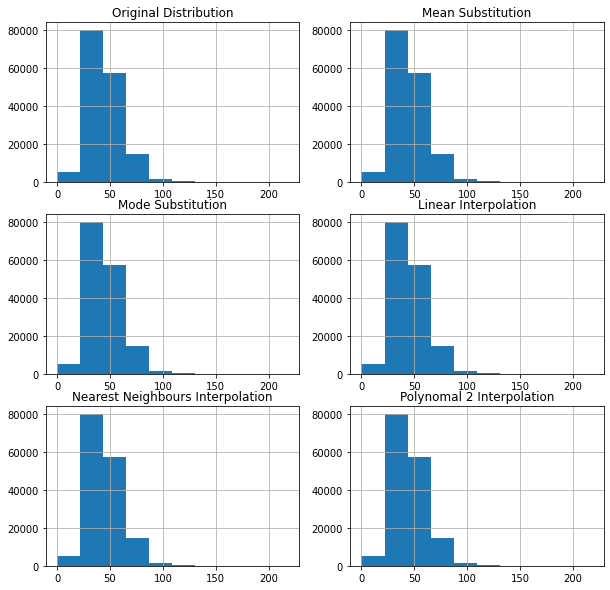

In [113]:
plot_distr_interpolation('1stIn')

In [114]:
print(df_matches['1stIn'].describe())
print("-------------")
print(df_matches_linear.describe())

count    159886.000000
mean         44.619929
std          16.046677
min           0.000000
25%          33.000000
50%          42.000000
75%          54.000000
max         218.000000
Name: 1stIn, dtype: float64
-------------
count    159898.000000
mean         44.620117
std          16.046311
min           0.000000
25%          33.000000
50%          42.000000
75%          54.000000
max         218.000000
Name: 1stIn, dtype: float64


In [115]:
inter_df['1stIn'] = df_matches['1stIn'].interpolate(method='linear').round()

In [116]:
print_stats_change("1stIn", df_matches, inter_df)

The mean of 1stIn has changed of 0.00042834481591605834 %
The std of 1stIn has changed of 0.0022520682401770496 %


In [117]:
old_na = df_matches.isna().sum()['1stIn']
df_matches = inter_df.copy()
print(f"A total of {old_na} missing values have been filled with linear interpolation")

A total of 12 missing values have been filled with linear interpolation


##### bpFaced (breakpoints faced)

In [118]:
df_matches_linear= df_matches['bpFaced'].interpolate(method='linear')
df_matches_nn= df_matches['bpFaced'].interpolate(method='nearest')
df_matches_pol_2= df_matches['bpFaced'].interpolate(method='polynomial', order=2)
df_matches_mean = df_matches['bpFaced'].fillna(df_matches['bpFaced'].mean())
df_matches_mode = df_matches['bpFaced'].fillna(df_matches['bpFaced'].mode()[0])

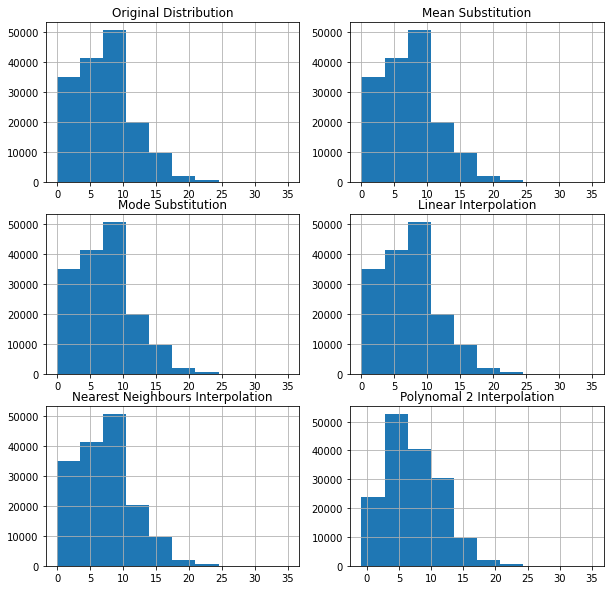

In [119]:
plot_distr_interpolation('bpFaced')

In [120]:
print(df_matches['bpFaced'].describe())
print("------------")
print(df_matches_linear.describe())

count    159883.000000
mean          7.100011
std           4.306053
min           0.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          35.000000
Name: bpFaced, dtype: float64
------------
count    159898.000000
mean          7.100120
std           4.305951
min           0.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          35.000000
Name: bpFaced, dtype: float64


In [121]:
inter_df['bpFaced'] = df_matches['bpFaced'].interpolate(method='linear').round()

In [122]:
print_stats_change("bpFaced", df_matches, inter_df)

The mean of bpFaced has changed of 0.001541459291303679 %
The std of bpFaced has changed of 0.002340531069573558 %


In [123]:
old_na = df_matches.isna().sum()['bpFaced']
df_matches = inter_df.copy()
print(f"A total of {old_na} missing values have been filled with linear interpolation")

A total of 15 missing values have been filled with linear interpolation


##### bpSaved (breakpoints saved)

In [124]:
df_matches_linear= df_matches['bpSaved'].interpolate(method='linear')
df_matches_nn= df_matches['bpSaved'].interpolate(method='nearest')
df_matches_pol_2= df_matches['bpSaved'].interpolate(method='polynomial', order=2)
df_matches_mean = df_matches['bpSaved'].fillna(df_matches['bpSaved'].mean())
df_matches_mode = df_matches['bpSaved'].fillna(df_matches['bpSaved'].mode()[0])

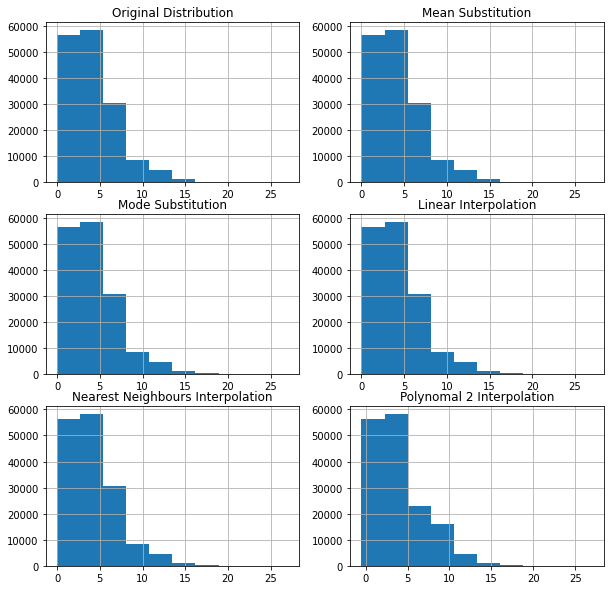

In [125]:
plot_distr_interpolation('bpSaved')

In [126]:
print(df_matches['bpSaved'].describe())
print("------------")
print(df_matches_linear.describe())

count    159887.000000
mean          4.096274
std           3.096205
min           0.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          27.000000
Name: bpSaved, dtype: float64
------------
count    159898.000000
mean          4.096299
std           3.096140
min           0.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          27.000000
Name: bpSaved, dtype: float64


In [127]:
inter_df['bpSaved'] = df_matches['bpSaved'].interpolate(method='linear').round()

In [128]:
print_stats_change("bpSaved", df_matches, inter_df)

The mean of bpSaved has changed of 0.0007543646542319739 %
The std of bpSaved has changed of 0.0020388642276121306 %


In [129]:
old_na = df_matches.isna().sum()['bpSaved']
df_matches = inter_df.copy()
print(f"A total of {old_na} missing values have been filled with linear interpolation")

A total of 11 missing values have been filled with linear interpolation


##### 1stWon (ratio of first serves won )

In [130]:
df_matches_linear= df_matches['1stWon'].interpolate(method='linear')
df_matches_nn= df_matches['1stWon'].interpolate(method='nearest')
df_matches_pol_2= df_matches['1stWon'].interpolate(method='polynomial', order=2)
df_matches_mean = df_matches['1stWon'].fillna(df_matches['1stWon'].mean())
df_matches_mode = df_matches['1stWon'].fillna(df_matches['1stWon'].mode()[0])

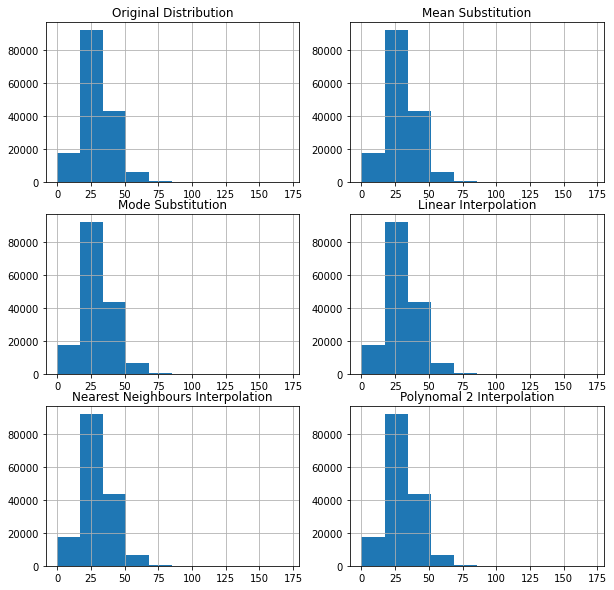

In [131]:
plot_distr_interpolation('1stWon')

In [132]:
print(df_matches['1stWon'].describe())
print("-----------")
print(df_matches_linear.describe())

count    159888.000000
mean         30.310167
std          11.571494
min           0.000000
25%          22.000000
50%          29.000000
75%          37.000000
max         171.000000
Name: 1stWon, dtype: float64
-----------
count    159898.000000
mean         30.310554
std          11.571435
min           0.000000
25%          22.000000
50%          29.000000
75%          37.000000
max         171.000000
Name: 1stWon, dtype: float64


In [133]:
inter_df['1stWon'] = df_matches['1stWon'].interpolate(method='linear')

In [134]:
print_stats_change("1stWon", df_matches, inter_df)

The mean of 1stWon has changed of 0.001277166625884722 %
The std of 1stWon has changed of 0.0005089518533011122 %


In [135]:
old_na = df_matches.isna().sum()['1stWon']
df_matches = inter_df.copy()
print(f"A total of {old_na} missing values have been filled with linear interpolation")

A total of 10 missing values have been filled with linear interpolation


##### 2ndWon (ratio of second serves won)

In [136]:
df_matches_linear= df_matches['2ndWon'].interpolate(method='linear')
df_matches_nn= df_matches['2ndWon'].interpolate(method='nearest')
df_matches_pol_2= df_matches['2ndWon'].interpolate(method='polynomial', order=2)
df_matches_mean = df_matches['2ndWon'].fillna(df_matches['2ndWon'].mean())
df_matches_mode = df_matches['2ndWon'].fillna(df_matches['2ndWon'].mode()[0])

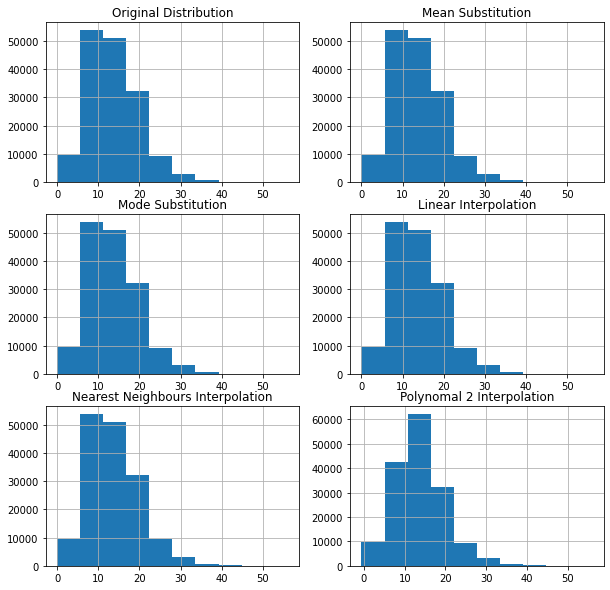

In [137]:
plot_distr_interpolation('2ndWon')

In [138]:
print(df_matches['2ndWon'].describe())
print("-------------")
print(df_matches_linear.describe())

count    159883.000000
mean         13.668032
std           6.014787
min           0.000000
25%           9.000000
50%          13.000000
75%          17.000000
max          56.000000
Name: 2ndWon, dtype: float64
-------------
count    159898.000000
mean         13.667870
std           6.014595
min           0.000000
25%           9.000000
50%          13.000000
75%          17.000000
max          56.000000
Name: 2ndWon, dtype: float64


In [139]:
inter_df['2ndWon'] = df_matches['2ndWon'].interpolate(method='linear')

In [140]:
print_stats_change("2ndWon", df_matches, inter_df)

The mean of 2ndWon has changed of 0.0011906012646526497 %
The std of 2ndWon has changed of 0.0031841044352552555 %


In [141]:
old_na = df_matches.isna().sum()['2ndWon']
df_matches = inter_df.copy()
print(f"A total of {old_na} missing values have been filled with linear interpolation")

A total of 15 missing values have been filled with linear interpolation


##### svpt (total service points)

In [142]:
df_matches_linear= df_matches['svpt'].interpolate(method='linear')
df_matches_nn= df_matches['svpt'].interpolate(method='nearest')
df_matches_pol_2= df_matches['svpt'].interpolate(method='polynomial', order=2)
df_matches_mean = df_matches['svpt'].fillna(df_matches['svpt'].mean())
df_matches_mode = df_matches['svpt'].fillna(df_matches['svpt'].mode()[0])

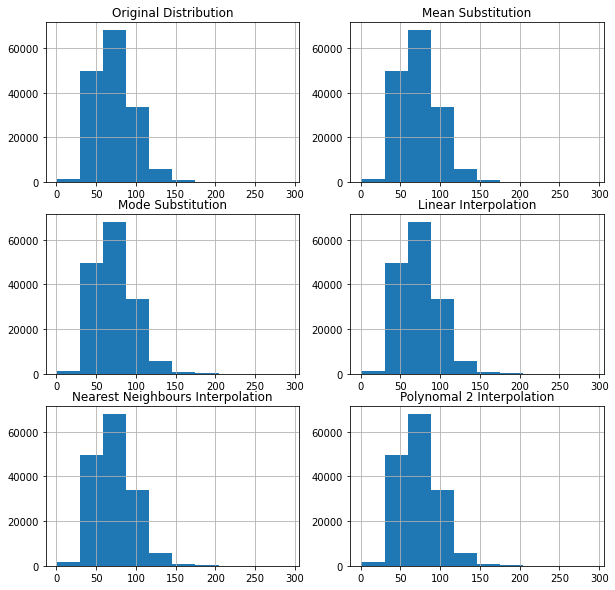

In [143]:
plot_distr_interpolation('svpt')

In [144]:
print(df_matches['svpt'].describe())
print("------------")
print(df_matches_linear.describe())

count    159888.000000
mean         72.704925
std          24.039072
min           1.000000
25%          55.000000
50%          69.000000
75%          88.000000
max         291.000000
Name: svpt, dtype: float64
------------
count    159898.000000
mean         72.705562
std          24.038879
min           1.000000
25%          55.000000
50%          69.000000
75%          88.000000
max         291.000000
Name: svpt, dtype: float64


In [145]:
inter_df['svpt'] = df_matches['svpt'].interpolate(method='linear').round()

In [146]:
print_stats_change("svpt", df_matches, inter_df)

The mean of svpt has changed of 0.0008769676582732252 %
The std of svpt has changed of 0.0007903313064564241 %


In [147]:
old_na = df_matches.isna().sum()['svpt']
df_matches = inter_df.copy()
print(f"A total of {old_na} missing values have been filled with linear interpolation")

A total of 10 missing values have been filled with linear interpolation


##### SvGms (serve games) 

In [148]:
df_matches_linear= df_matches['SvGms'].interpolate(method='linear')
df_matches_nn= df_matches['SvGms'].interpolate(method='nearest')
df_matches_pol_2= df_matches['SvGms'].interpolate(method='polynomial', order=2)
df_matches_mean = df_matches['SvGms'].fillna(df_matches['SvGms'].mean())
df_matches_mode = df_matches['SvGms'].fillna(df_matches['SvGms'].mode()[0])

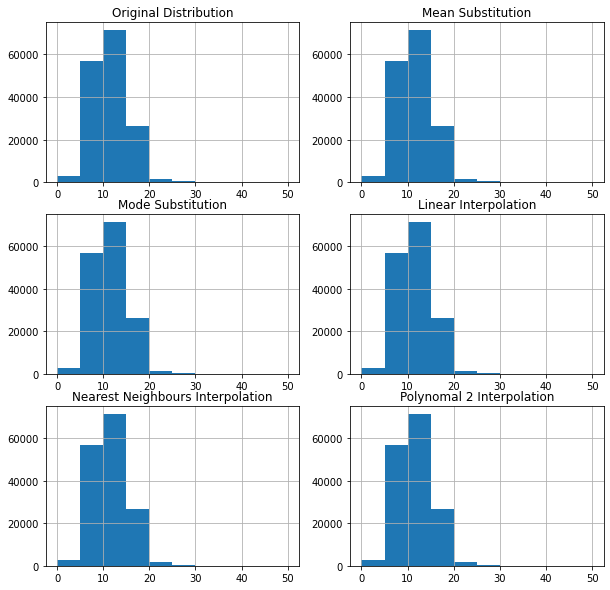

In [149]:
plot_distr_interpolation('SvGms')

In [150]:
print(df_matches['SvGms'].describe())
print("------------")
print(df_matches_linear.describe())

count    159890.000000
mean         11.081212
std           3.494939
min           0.000000
25%           9.000000
50%          10.000000
75%          14.000000
max          50.000000
Name: SvGms, dtype: float64
------------
count    159898.000000
mean         11.081324
std           3.494906
min           0.000000
25%           9.000000
50%          10.000000
75%          14.000000
max          50.000000
Name: SvGms, dtype: float64


In [151]:
inter_df['SvGms'] = df_matches['SvGms'].interpolate(method='linear').round()

In [152]:
print_stats_change("SvGms", df_matches, inter_df)

The mean of SvGms has changed of 0.0009792121045371822 %
The std of SvGms has changed of 0.0009879215175594774 %


In [153]:
old_na = df_matches.isna().sum()['SvGms']
df_matches = inter_df.copy()
print(f"A total of {old_na} missing values have been filled with linear interpolation")

A total of 8 missing values have been filled with linear interpolation


All the missing values are now gone

In [154]:
df_matches.isna().sum()

tourney_name           0
surface                0
tourney_level          0
tourney_date           0
best_of               10
round                  0
minutes                0
tourney_spectators     0
totalGames             0
result                 0
entry                  0
name                   0
hand                   0
ht                     0
ioc                    0
age                    0
ace                    0
df                     0
svpt                   0
1stIn                  0
1stWon                 0
2ndWon                 0
SvGms                  0
bpSaved                0
bpFaced                0
rank                   0
sets                   0
games                  0
sex                    0
dtype: int64

In [155]:
pd.DataFrame.to_csv(df_matches, path_or_buf='data/df_matches.csv')

## Creating players profiles <a name="creating-players-profiles"></a>

We create a new dataset containing the indicators for the players which will make the player profile.

In [156]:
def create_df(x):
    wins = x['result'].value_counts()['w'] if ('w' in x['result'].value_counts()) else 0
    losses = x['result'].value_counts()['l'] if ('l' in x['result'].value_counts()) else 0

    rateo_all = wins / (wins + losses)

    x.reset_index(inplace=True)
    tourGroups = x.groupby('tourney_date')
    
    max_weight = df_matches['tourney_spectators'].max()
    spect_weight = tourGroups['tourney_spectators'].agg('max') / max_weight
    
    sumAceTournaments = tourGroups['ace'].agg('sum')
    sumDfTournaments = tourGroups['df'].agg('sum')
    sumBpFaced = tourGroups['bpFaced'].agg('sum')
    sumBpSaved = tourGroups['bpSaved'].agg('sum')
    sumGames = tourGroups['totalGames'].agg('sum') 
    sumGamesWon = tourGroups['games'].agg('sum') 
    sum1stWon = tourGroups['1stWon'].agg('sum')
    sum2ndWon = tourGroups['2ndWon'].agg('sum')
    sumSvpt = tourGroups['svpt'].agg('sum')
    sum1stIn = tourGroups['1stIn'].agg('sum')

    return pd.Series(
        {
            'ioc': x['ioc'].iloc[0],
            'sex': x['sex'].iloc[0],
            'hand': x['hand'].iloc[0],
            'rank': round(np.average(x['rank']),2),
            'ht': x['ht'].iloc[0],
            'age': x['age'].iloc[0],

            'tourPlayed': x['tourney_name'].nunique(), 
            'maxAceSvpt': round(((sumAceTournaments / sumSvpt) * spect_weight).max() * 100, 2),
            'avgDfSvpt': round(np.average(sumDfTournaments / sumSvpt, weights = spect_weight) * 100,2),
            '1sv2svWon': round(np.average(((sum1stWon + sum2ndWon) / sumSvpt), weights=spect_weight) * 100, 2),
            'bpS_bpF': round(np.average(sumBpSaved / sumBpFaced, weights=spect_weight) * 100, 2),

            'win_ratio': round(x[x['result'] =='w'].shape[0] / x.shape[0] * 100, 2),
        }
    )

df_new = df_matches.groupby('name').apply(create_df)
df_new.reset_index(inplace = True)

print(f"New dataset has {df_new.shape[0]} rows, each row correspond to a profile for a given player")
df_new.head()

New dataset has 2109 rows, each row correspond to a profile for a given player


,name,ioc,sex,hand,rank,ht,age,tourPlayed,maxAceSvpt,avgDfSvpt,1sv2svWon,bpS_bpF,win_ratio
0,Aaron Addison,AUS,m,R,1398.00,186.54,24.0,5,6.03,6.95,57.24,61.81,18.18
1,Abbie Myers,AUS,f,R,436.00,173.92,26.0,5,3.06,7.32,49.14,41.58,0.00
2,Abhinav Sanjeev Shanmugam,IND,m,U,918.00,186.54,21.0,5,4.06,4.72,59.64,61.79,46.67
3,Abigail Spears,USA,f,R,493.22,173.92,37.0,8,3.52,4.41,53.44,48.60,0.00
4,Abigail Tere Apisah,PNG,f,U,530.00,173.92,26.0,12,0.76,5.11,52.57,55.29,57.14


In [157]:
print(f"There are {df_new.isna().sum()['bpS_bpF']} missing values for the attribute bpS_bpF which have dropped")
print(df_new.shape[0])
df_new.dropna(inplace=True)
print(df_new.shape[0])
df_new.reset_index(drop=True, inplace=True)

There are 138 missing values for the attribute bpS_bpF which have dropped
2109
1971


In [158]:
df_new.isna().sum()

name          0
ioc           0
sex           0
hand          0
rank          0
ht            0
age           0
tourPlayed    0
maxAceSvpt    0
avgDfSvpt     0
1sv2svWon     0
bpS_bpF       0
win_ratio     0
dtype: int64

In [159]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        1971 non-null   object 
 1   ioc         1971 non-null   object 
 2   sex         1971 non-null   object 
 3   hand        1971 non-null   object 
 4   rank        1971 non-null   float64
 5   ht          1971 non-null   float64
 6   age         1971 non-null   float64
 7   tourPlayed  1971 non-null   int64  
 8   maxAceSvpt  1971 non-null   float64
 9   avgDfSvpt   1971 non-null   float64
 10  1sv2svWon   1971 non-null   float64
 11  bpS_bpF     1971 non-null   float64
 12  win_ratio   1971 non-null   float64
dtypes: float64(8), int64(1), object(4)
memory usage: 200.3+ KB


## Correlation on new dataset<a name="correlation-new-dataset"></a>

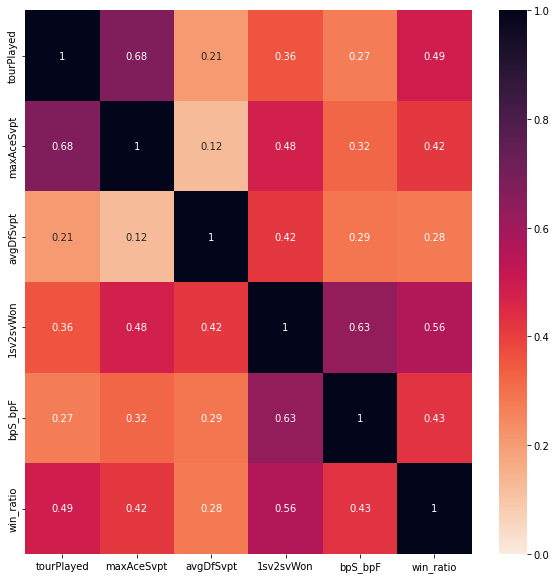

In [160]:
plt.figure(figsize=(10, 10))
cmap = sns.cm.rocket_r
sns.heatmap(df_new.iloc[:, 7 :].corr().abs(), vmin=0, vmax=1, annot=True, cmap=cmap);

In [161]:
c = df_new.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)
print(so[10:50])

tourPlayed  maxAceSvpt    0.676357
bpS_bpF     1sv2svWon     0.631163
1sv2svWon   bpS_bpF       0.631163
            win_ratio     0.560100
win_ratio   1sv2svWon     0.560100
ht          1sv2svWon     0.492035
1sv2svWon   ht            0.492035
win_ratio   tourPlayed    0.486142
tourPlayed  win_ratio     0.486142
1sv2svWon   maxAceSvpt    0.478903
maxAceSvpt  1sv2svWon     0.478903
rank        tourPlayed    0.461043
tourPlayed  rank          0.461043
bpS_bpF     win_ratio     0.428492
win_ratio   bpS_bpF       0.428492
1sv2svWon   avgDfSvpt     0.417604
avgDfSvpt   1sv2svWon     0.417604
win_ratio   rank          0.417143
rank        win_ratio     0.417143
maxAceSvpt  win_ratio     0.415558
win_ratio   maxAceSvpt    0.415558
maxAceSvpt  rank          0.377972
rank        maxAceSvpt    0.377972
tourPlayed  1sv2svWon     0.356863
1sv2svWon   tourPlayed    0.356863
age         tourPlayed    0.338327
tourPlayed  age           0.338327
maxAceSvpt  bpS_bpF       0.324140
bpS_bpF     maxAceSv

## PCA<a name="pca"></a>

In [162]:
df_num = df_new.copy()
cat_feature = df_num[['ioc', 'name', 'hand', 'sex']]
df_num.drop(columns=cat_feature, inplace=True) 

### Normalization

We perform normalization before applying PCA

In [163]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
df_normalized = minmax_scaler.fit_transform(df_num[['tourPlayed', 'maxAceSvpt','avgDfSvpt','1sv2svWon', 'bpS_bpF', 'win_ratio']])

We start PCA by plotting the variance that is obtained by using different number of components.

[[<matplotlib.axis.XTick at 0x7f2a0dc609a0>,

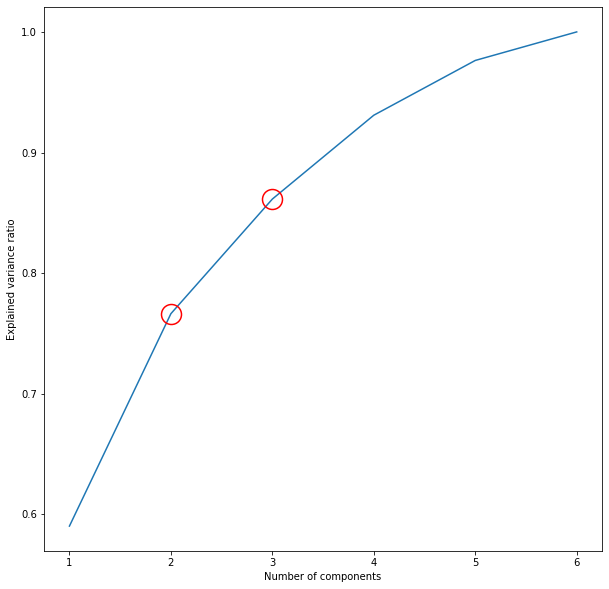

In [164]:
pca = PCA()

pca.fit_transform(df_normalized)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig = plt.figure(figsize=(10, 10))
ax = sns.lineplot(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul)
ax.set_xlabel("Number of components")
ax.set_ylabel("Explained variance ratio")

lines = ax.get_lines()
props = {'marker':'o','markersize':20, 'fillstyle':'none','markeredgewidth':1.5,
         'markeredgecolor':'red','markevery': [1, 2]}
line = lines[0]
line.set(**props)
ax.set(xticks=range(1, exp_var_cumul.shape[0] + 1))

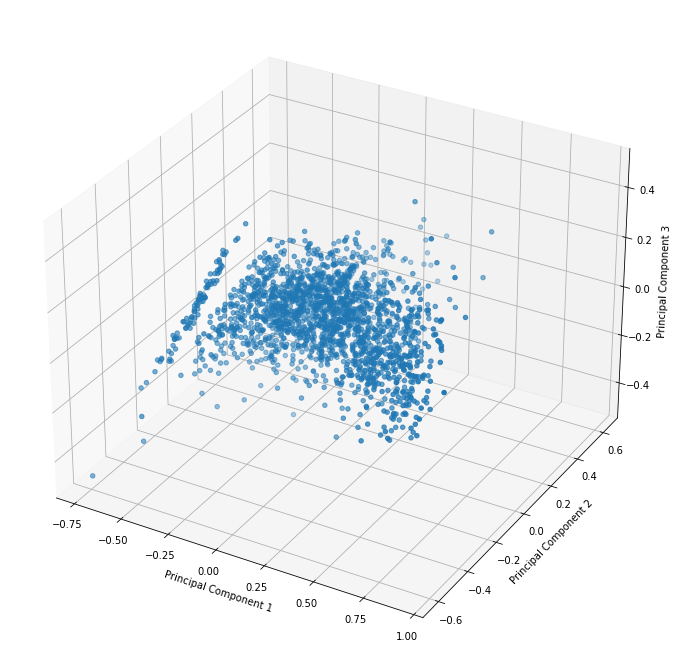

In [165]:
threed_pca = PCA(n_components=3).fit_transform(df_normalized)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(threed_pca[:, 0], threed_pca[:, 1], threed_pca[:, 2])
ax.set_xlabel(f"Principal Component 1")
ax.set_ylabel(f"Principal Component 2")
ax.set_zlabel(f"Principal Component 3")
plt.show()

In [166]:
df_new.isna().sum()

name          0
ioc           0
sex           0
hand          0
rank          0
ht            0
age           0
tourPlayed    0
maxAceSvpt    0
avgDfSvpt     0
1sv2svWon     0
bpS_bpF       0
win_ratio     0
dtype: int64

## Write the new dataset to a csv file

In [167]:
pd.DataFrame.to_csv(df_num, path_or_buf='data/df_new_num.csv')
pd.DataFrame.to_csv(df_new, path_or_buf='data/df_new_all.csv')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bd0371f1-26bc-4fa2-b3a3-1a163a949e34' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>